<a href="https://colab.research.google.com/github/Tejaswitallapally/2697174-DataScience/blob/main/Weather_Dataset1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Title: Predicting Apparent Temperature with Machine Learning

Abstract:
We use machine learning to forecast apparent temperature, indicating how humans perceive outdoor temperature. By analyzing past weather data, our models aim to accurately predict environmental conditions. This research can assist in various areas such as weather forecasting and public health planning.


Here are the variable descriptions for each column in the provided dataset:

Formatted Date: The date and time of the weather observation in a standardized format

Summary: A brief description of the weather conditions at the time of observation (e.g., "Partly Cloudy").

Precip Type: The type of precipitation observed, if any (e.g., "rain/snow").

Temperature (C): The air temperature in degrees Celsius at the time of observation

Apparent Temperature (C): The perceived outdoor temperature in degrees Celsius, which considers factors such as humidity and wind chill

Humidity: The relative humidity expressed as a decimal value ranging from 0 to 1

Wind Speed (km/h): The speed of the wind in kilometers per hour at the time of observation

Wind Bearing (degrees): The direction from which the wind is blowing, measured in degrees clockwise from true north

Visibility (km): The visibility distance in kilometers at the time of observation .

Loud Cover: A numerical value indicating the extent of cloud cover, typically ranging from 0 to 1

Pressure (millibars): The atmospheric pressure in millibars at the time of observation

Daily Summary: A summary of the overall weather conditions for the day

In [2]:
##Installing all the required libraries for the Assignment
!pip install requests
!pip install tabulate
!pip install "colorama>=0.3.8"
!pip install future
!pip install h2o

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.2/265.2 MB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.44.0.3-py2.py3-none-any.whl size=265293968 sha256=aa75bfc4b16c7c8d96e3987382dcbf9e264feeeec9c7d3d02d318f779e5092d1
  Stored in directory: /root/.cache/pip/wheels/77/9a/1c/2da26f943fd46b57f3c20b54847b936b9152b831dc7447cf71
Successfully built h2o


In [3]:
# Importing all the libararies required for the assignment
import h2o
from h2o.automl import H2OAutoML
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from scipy.stats import pearsonr

sns.set(rc={"figure.figsize": (16, 8)})

In [4]:
# Setting up maximum runtime for the AutoML
min_mem_size = 6
run_time = 222

In [5]:
pct_memory = 0.5
virtual_memory = psutil.virtual_memory()
min_mem_size = int(round(int(pct_memory * virtual_memory.available) / 1073741824, 0))
print(min_mem_size)

6


In [6]:
# 65535 Highest port no
# Start the H2O server on a random port
port_no = random.randint(5555, 55555)
#  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
try:
    h2o.init(
        strict_version_check=False, min_mem_size_GB=min_mem_size, port=port_no
    )  # start h2o
except:
    logging.critical("h2o.init")
    h2o.download_all_logs(dirname=logs_path, filename=logfile)
    h2o.cluster().shutdown()
    sys.exit(2)

Checking whether there is an H2O instance running at http://localhost:14868..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.21" 2023-10-17; OpenJDK Runtime Environment (build 11.0.21+9-post-Ubuntu-0ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.21+9-post-Ubuntu-0ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp2s0oeis0
  JVM stdout: /tmp/tmp2s0oeis0/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp2s0oeis0/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:14868
Connecting to H2O server at http://127.0.0.1:14868 ... successful.


--------------------------  -----------------------------------------------------------------------------------------
H2O_cluster_uptime:         08 secs
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.44.0.3
H2O_cluster_version_age:    1 month and 30 days
H2O_cluster_name:           H2O_from_python_unknownUser_nrr45z
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    6 Gb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:14868
H2O_connection_proxy:       {"http": null, "https": null, "colab_language_server": "/usr/colab/bin/language_service"}
H2O_internal_security:      False
Python_version:             3.10.12 final
--------------------------  -----------------------------------------------------------------------------------------

Exploratory Data Analysis (EDA)

In [9]:
from google.colab import drive
drive.mount('/content/drive')

pandas_df = pd.read_csv('/content/drive/MyDrive/datascience/weatherHistory.csv')
pandas_df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Formatted Date        Summary Precip Type  \
0      2006-04-01 00:00:00.000 +0200  Partly Cloudy        rain   
1      2006-04-01 01:00:00.000 +0200  Partly Cloudy        rain   
2      2006-04-01 02:00:00.000 +0200  Mostly Cloudy        rain   
3      2006-04-01 03:00:00.000 +0200  Partly Cloudy        rain   
4      2006-04-01 04:00:00.000 +0200  Mostly Cloudy        rain   
...                              ...            ...         ...   
96448  2016-09-09 19:00:00.000 +0200  Partly Cloudy        rain   
96449  2016-09-09 20:00:00.000 +0200  Partly Cloudy        rain   
96450  2016-09-09 21:00:00.000 +0200  Partly Cloudy        rain   
96451  2016-09-09 22:00:00.000 +0200  Partly Cloudy        rain   
96452  2016-09-09 23:00:00.000 +0200  Partly Cloudy        rain   

       Temperature (C)  Apparent Temperature (C)  Humidity  Wind Speed (km/h)  \
0             9.472222                  7.388889      0.89            14.1197   
1             9.355556                  7.227778      0.86            14.2646   
2             9.377778                  9.377778      0.89             3.9284   
3             8.288889                  5.944444      0.83            14.1036   
4             8.755556                  6.977778      0.83            11.0446   
...                ...                       ...       ...                ...   
96448        26.016667                 26.016667      0.43            10.9963   
96449        24.583333                 24.583333      0.48            10.0947   
96450        22.038889                 22.038889      0.56             8.9838   
96451        21.522222                 21.522222      0.60            10.5294   
96452        20.438889                 20.438889      0.61             5.8765   

       Wind Bearing (degrees)  Visibility (km)  Loud Cover  \
0                       251.0          15.8263         0.0   
1                       259.0          15.8263         0.0   
2                       204.0          14.9569         0.0   
3                       269.0          15.8263         0.0   
4                       259.0          15.8263         0.0   
...                       ...              ...         ...   
96448                    31.0          16.1000         0.0   
96449                    20.0          15.5526         0.0   
96450                    30.0          16.1000         0.0   
96451                    20.0          16.1000         0.0   
96452                    39.0          15.5204         0.0   

       Pressure (millibars)                           Daily Summary  
0                   1015.13       Partly cloudy throughout the day.  
1                   1015.63       Partly cloudy throughout the day.  
2                   1015.94       Partly cloudy throughout the day.  
3                   1016.41       Partly cloudy throughout the day.  
4                   1016.51       Partly cloudy throughout the day.  
...                     ...                                     ...  
96448               1014.36  Partly cloudy starting in the morning.  
96449               1015.16  Partly cloudy starting in the morning.  
96450               1015.66  Partly cloudy starting in the morning.  
96451               1015.95  Partly cloudy starting in the morning.  
96452               1016.16  Partly cloudy starting in the morning.  

[96453 rows x 12 columns]

In [10]:
pandas_df.head()

Formatted Date        Summary Precip Type  Temperature (C)  \
0  2006-04-01 00:00:00.000 +0200  Partly Cloudy        rain         9.472222   
1  2006-04-01 01:00:00.000 +0200  Partly Cloudy        rain         9.355556   
2  2006-04-01 02:00:00.000 +0200  Mostly Cloudy        rain         9.377778   
3  2006-04-01 03:00:00.000 +0200  Partly Cloudy        rain         8.288889   
4  2006-04-01 04:00:00.000 +0200  Mostly Cloudy        rain         8.755556   

   Apparent Temperature (C)  Humidity  Wind Speed (km/h)  \
0                  7.388889      0.89            14.1197   
1                  7.227778      0.86            14.2646   
2                  9.377778      0.89             3.9284   
3                  5.944444      0.83            14.1036   
4                  6.977778      0.83            11.0446   

   Wind Bearing (degrees)  Visibility (km)  Loud Cover  Pressure (millibars)  \
0                   251.0          15.8263         0.0               1015.13   
1                   259.0          15.8263         0.0               1015.63   
2                   204.0          14.9569         0.0               1015.94   
3                   269.0          15.8263         0.0               1016.41   
4                   259.0          15.8263         0.0               1016.51   

                       Daily Summary  
0  Partly cloudy throughout the day.  
1  Partly cloudy throughout the day.  
2  Partly cloudy throughout the day.  
3  Partly cloudy throughout the day.  
4  Partly cloudy throughout the day.

In [11]:
pandas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Formatted Date            96453 non-null  object 
 1   Summary                   96453 non-null  object 
 2   Precip Type               95936 non-null  object 
 3   Temperature (C)           96453 non-null  float64
 4   Apparent Temperature (C)  96453 non-null  float64
 5   Humidity                  96453 non-null  float64
 6   Wind Speed (km/h)         96453 non-null  float64
 7   Wind Bearing (degrees)    96453 non-null  float64
 8   Visibility (km)           96453 non-null  float64
 9   Loud Cover                96453 non-null  float64
 10  Pressure (millibars)      96453 non-null  float64
 11  Daily Summary             96453 non-null  object 
dtypes: float64(8), object(4)
memory usage: 8.8+ MB


In [12]:
pandas_df.isnull().sum()  # Checking for any null values in the dataset

Formatted Date                0
Summary                       0
Precip Type                 517
Temperature (C)               0
Apparent Temperature (C)      0
Humidity                      0
Wind Speed (km/h)             0
Wind Bearing (degrees)        0
Visibility (km)               0
Loud Cover                    0
Pressure (millibars)          0
Daily Summary                 0
dtype: int64

In [13]:
new_df = pandas_df.dropna(axis=0, how='any')
print(new_df.isnull().sum())

Formatted Date              0
Summary                     0
Precip Type                 0
Temperature (C)             0
Apparent Temperature (C)    0
Humidity                    0
Wind Speed (km/h)           0
Wind Bearing (degrees)      0
Visibility (km)             0
Loud Cover                  0
Pressure (millibars)        0
Daily Summary               0
dtype: int64


In [14]:
print("Num of Duplicates:" + str(new_df.duplicated().sum()))
new_df=new_df.drop_duplicates()
print("Num_of duplicates after :" + str(new_df.duplicated().sum()))
new_df=new_df.reset_index(drop=True)

Num of Duplicates:24
Num_of duplicates after :0


In [15]:
new_df.shape

(95912, 12)

In [16]:
final_df = new_df.drop(['Formatted Date', 'Daily Summary', 'Loud Cover'], axis=1)

We removed the "Formatted Date" column due to its uniformity of unique values, making it less useful for pattern recognition. Similarly, the "Loud Cover" column, containing only the value 0, was dropped. Additionally, we eliminated the "Daily Summary" column, as its information significantly overlapped with the "Summary" column.







In [17]:
final_df.shape

(95912, 9)

In [18]:
columns = list(final_df.columns)
print(columns)

['Summary', 'Precip Type', 'Temperature (C)', 'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)', 'Pressure (millibars)']


In [19]:
final_df.describe()  # Statistical description of our dataset

Temperature (C)  Apparent Temperature (C)      Humidity  \
count     95912.000000              95912.000000  95912.000000   
mean         11.937975                 10.859194      0.734844   
std           9.569620                 10.716711      0.195717   
min         -21.822222                -27.716667      0.000000   
25%           4.594444                  2.272222      0.600000   
50%          12.022222                 12.022222      0.780000   
75%          18.844444                 18.844444      0.890000   
max          39.905556                 39.344444      1.000000   

       Wind Speed (km/h)  Wind Bearing (degrees)  Visibility (km)  \
count       95912.000000            95912.000000     95912.000000   
mean           10.806764              187.506986        10.362306   
std             6.920504              107.378309         4.174204   
min             0.000000                0.000000         0.000000   
25%             5.812100              116.000000         8.355900   
50%             9.933700              180.000000        10.046400   
75%            14.135800              290.000000        14.812000   
max            63.852600              359.000000        16.100000   

       Pressure (millibars)  
count          95912.000000  
mean            1003.146959  
std              117.291484  
min                0.000000  
25%             1011.890000  
50%             1016.420000  
75%             1021.050000  
max             1046.380000

The dataset contains 95912 observations and 7 variables.

The "count" row indicates the number of observations for each variable, which is 95912 for all variables

The "mean" row shows the average value of each variable:

The "std" row indicates the standard deviation of each variable

The "min" and "max" rows show the smallest and largest values observed for each variable

The "25%", "50%", and "75%" rows show the values at the 25th, 50th, and 75th percentiles of the distribution, respectively. These percentiles help understand the distribution of values within each variable's dataset.

<ipython-input-20-49653c4159df>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  final_df.corr(), annot=True, cmap="Oranges"


<Axes: >

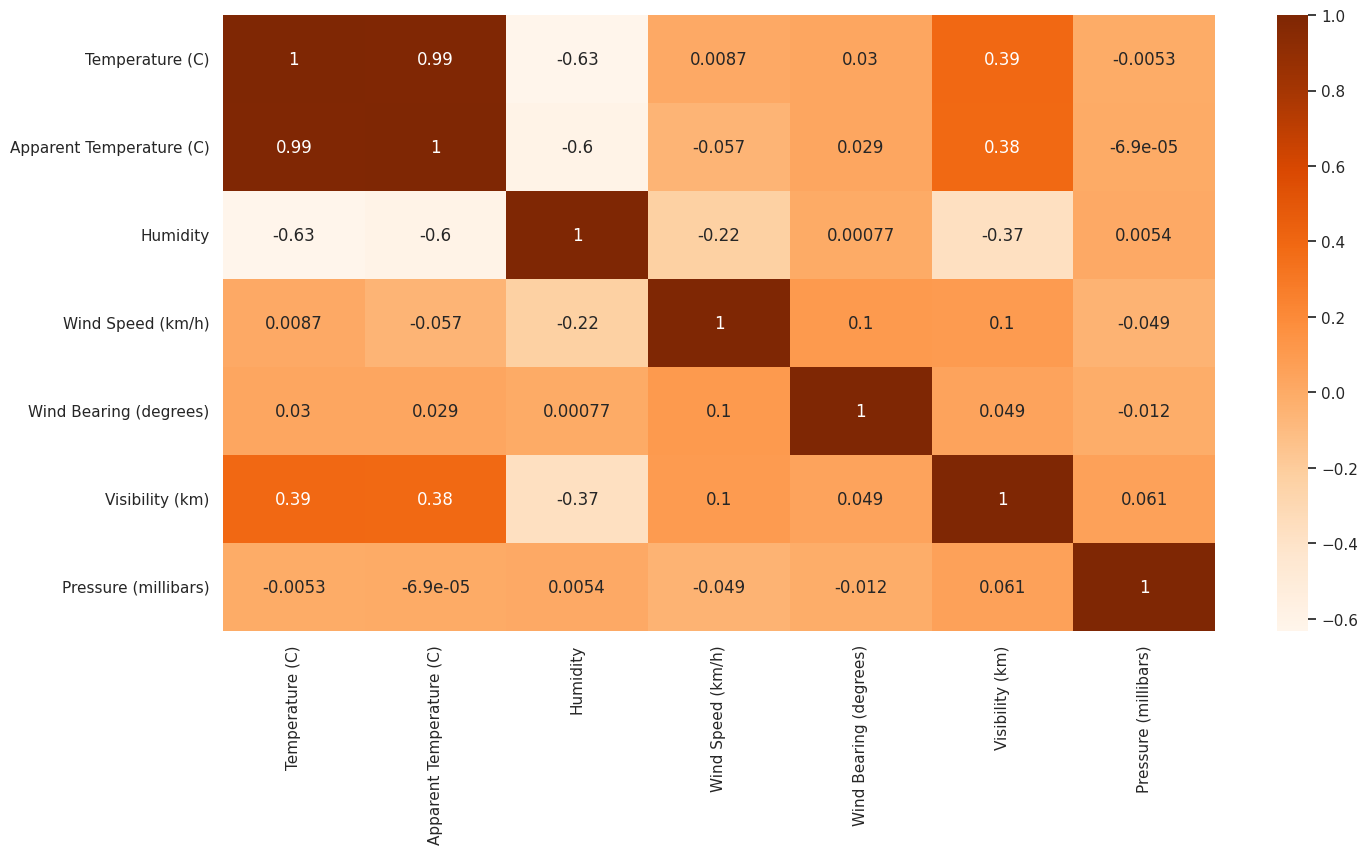

In [20]:
sns.heatmap(
    final_df.corr(), annot=True, cmap="Oranges"
)  # Heatmap showing correlation between the attributes.

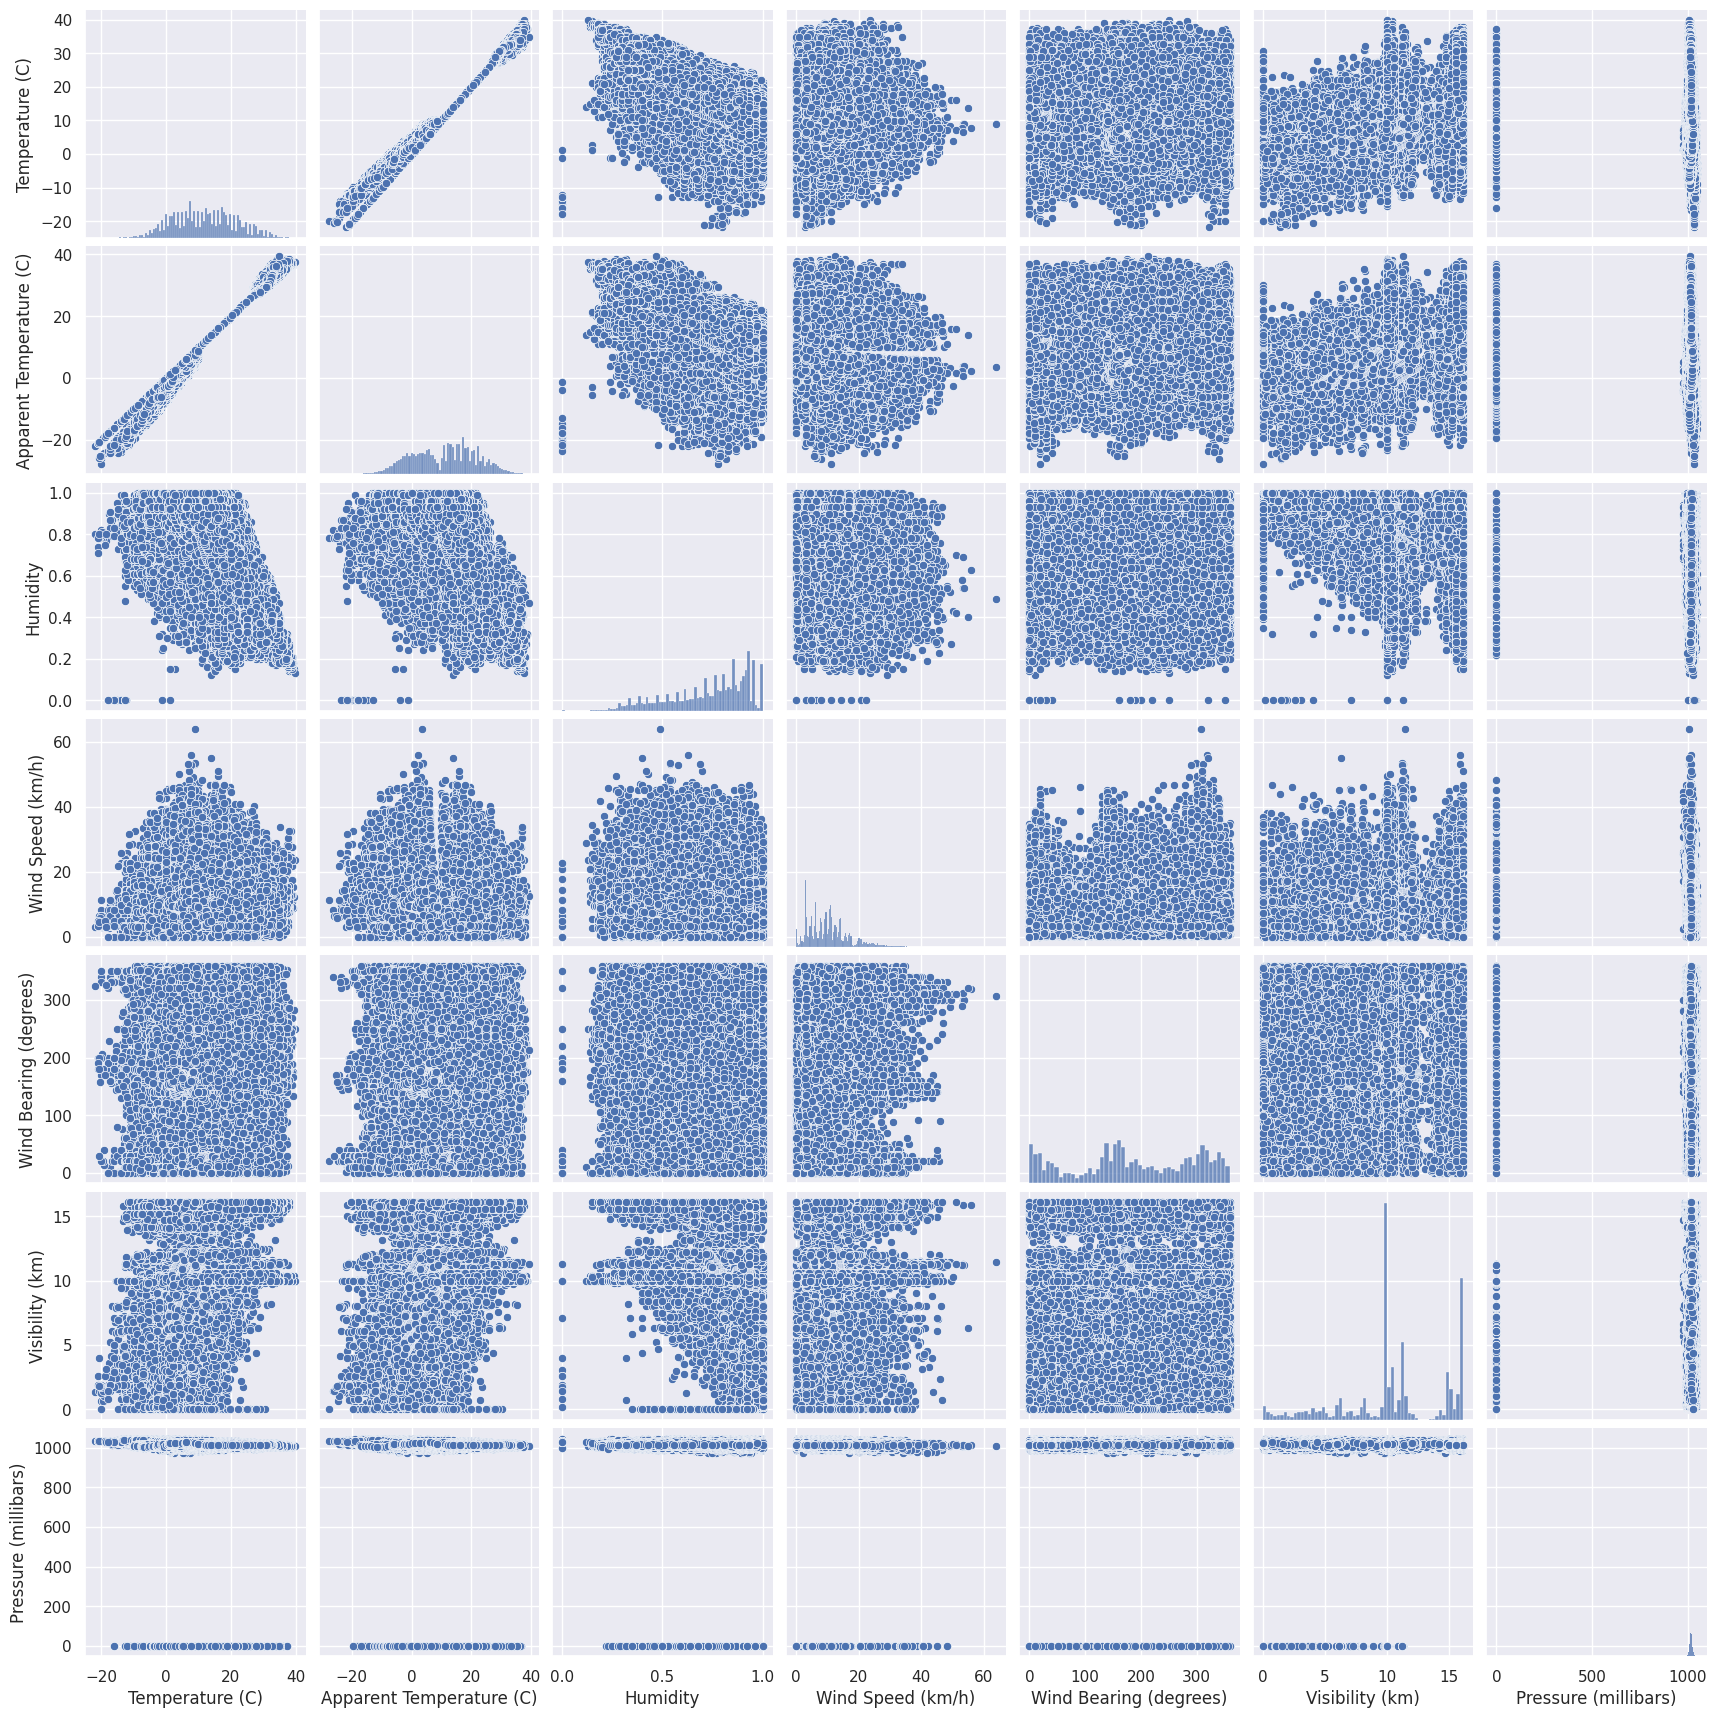

In [21]:
sns.pairplot(
    final_df
)

In [22]:
df = h2o.H2OFrame(
    final_df
)  # Converted Pandas Dataframe to H2O dataframe to proceed with AutoML

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [23]:
df.types  # Datatype of all attributes

{'Summary': 'enum',
 'Precip Type': 'enum',
 'Temperature (C)': 'real',
 'Apparent Temperature (C)': 'real',
 'Humidity': 'real',
 'Wind Speed (km/h)': 'real',
 'Wind Bearing (degrees)': 'int',
 'Visibility (km)': 'real',
 'Pressure (millibars)': 'real'}

In [24]:
pct_rows = 0.80  # Setting up the data split between training and test dataset.
df_train, df_test = df.split_frame([pct_rows])

In [25]:
print(df_train.shape)
print(df_test.shape)

(76793, 9)
(19119, 9)


In [26]:
df_train.head()

Summary        Precip Type      Temperature (C)    Apparent Temperature (C)    Humidity    Wind Speed (km/h)    Wind Bearing (degrees)    Visibility (km)    Pressure (millibars)
-------------  -------------  -----------------  --------------------------  ----------  -------------------  ------------------------  -----------------  ----------------------
Partly Cloudy  rain                     9.47222                     7.38889        0.89              14.1197                       251            15.8263                 1015.13
Mostly Cloudy  rain                     9.37778                     9.37778        0.89               3.9284                       204            14.9569                 1015.94
Partly Cloudy  rain                     8.28889                     5.94444        0.83              14.1036                       269            15.8263                 1016.41
Mostly Cloudy  rain                     8.75556                     6.97778        0.83              11.0446                       259            15.8263                 1016.51
Partly Cloudy  rain                     9.22222                     7.11111        0.85              13.9587                       258            14.9569                 1016.66
Partly Cloudy  rain                     7.73333                     5.52222        0.95              12.3648                       259             9.982                  1016.72
Partly Cloudy  rain                     8.77222                     6.52778        0.89              14.1519                       260             9.982                  1016.84
Partly Cloudy  rain                    10.8222                     10.8222         0.82              11.3183                       259             9.982                  1017.37
Partly Cloudy  rain                    16.0167                     16.0167         0.67              17.5651                       290            11.2056                 1017.42
Partly Cloudy  rain                    17.1444                     17.1444         0.54              19.7869                       316            11.4471                 1017.74
[10 rows x 9 columns]

In [27]:
X = df.columns
print(X)

['Summary', 'Precip Type', 'Temperature (C)', 'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)', 'Pressure (millibars)']


In [28]:
# Set target and predictor variables
y = "Apparent Temperature (C)"
X.remove(y)  # Removing the result frm our predictors data
print(X)

['Summary', 'Precip Type', 'Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)', 'Pressure (millibars)']


In [29]:
aml = H2OAutoML(max_runtime_secs=run_time, seed=1)  # Setting of AutoML

In [30]:
aml.train(x=X, y=y, training_frame=df_train)  # Trainig the dataset on different models

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_1_AutoML_1_20240220_44658


Model Summary for Stacked Ensemble: 
key                                   value
------------------------------------  ----------------
Stacking strategy                     cross_validation
Number of base models (used / total)  3/8
# GBM base models (used / total)      1/4
# XGBoost base models (used / total)  1/2
# GLM base models (used / total)      1/1
# DRF base models (used / total)      0/1
Metalearner algorithm                 GLM
Metalearner fold assignment scheme    Random
Metalearner nfolds                    5
Metalearner fold_column
Custom metalearner hyperparameters    None

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.02028911601233399
RMSE: 0.14243986805783693
MAE: 0.07408425826216837
RMSLE: NaN
Mean Residual Deviance: 0.02028911601233399
R^2: 0.9998205574468132
Null degrees of freedom: 9922
Residual degrees of freedom: 9919
Null deviance: 1122301.934512847
Residual deviance: 201.3288981903902
AIC: -10506.332164060164

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.040471014190835555
RMSE: 0.2011740892630946
MAE: 0.10913491762050428
RMSLE: NaN
Mean Residual Deviance: 0.040471014190835555
R^2: 0.9996474994303591
Null degrees of freedom: 76792
Residual degrees of freedom: 76789
Null deviance: 8817472.66226423
Residual deviance: 3107.890592756835
AIC: -28349.055429790544

Cross-Validation Metrics Summary: 
                        mean         sd           cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  -----------  -----------  ------------  ------------  ------------  ------------  ------------
mae                     0.109133     0.00210446   0.108127      0.112599      0.109176      0.108763      0.107
mean_residual_deviance  0.0404694    0.00311665   0.0395982     0.0457039     0.0392521     0.0403567     0.0374361
mse                     0.0404694    0.00311665   0.0395982     0.0457039     0.0392521     0.0403567     0.0374361
null_deviance           1.76349e+06  13267        1.76322e+06   1.77742e+06   1.76978e+06   1.76518e+06   1.74187e+06
r2                      0.999648     2.53326e-05  0.999655      0.999604      0.999658      0.999651      0.99967
residual_deviance       621.578      48.3838      608.546       703.337       605.346       616.166       574.495
rmse                    0.201055     0.00761981   0.198993      0.213785      0.198122      0.20089       0.193484
rmsle                   nan          0            nan           nan           nan           nan           nan

[tips]
Use `model.explain()` to inspect the model.
--
Use `h2o.display.toggle_user_tips()` to switch on/off this section.

In [31]:
print(
    aml.leaderboard
)  # Leaderboard showing the performance of different models on the dataset.

model_id                                                    rmse         mse       mae    rmsle    mean_residual_deviance
StackedEnsemble_AllModels_1_AutoML_1_20240220_44658     0.201174   0.040471   0.109135      nan                 0.040471
StackedEnsemble_BestOfFamily_2_AutoML_1_20240220_44658  0.201192   0.0404783  0.109137      nan                 0.0404783
StackedEnsemble_BestOfFamily_1_AutoML_1_20240220_44658  0.2012     0.0404814  0.109139      nan                 0.0404814
GBM_1_AutoML_1_20240220_44658                           0.209325   0.0438171  0.114126      nan                 0.0438171
XGBoost_1_AutoML_1_20240220_44658                       0.89277    0.797039   0.646871      nan                 0.797039
GLM_1_AutoML_1_20240220_44658                           1.06558    1.13545    0.841607      nan                 1.13545
DRF_1_AutoML_1_20240220_44658                           1.47081    2.16327    0.765584      nan                 2.16327
XRT_1_AutoML_1_20240220_44658 

In [32]:
model_index = 0
glm_index = 0
glm_model = ""
aml_leaderboard_df = aml.leaderboard.as_data_frame()
models_dict = {}
for m in aml_leaderboard_df["model_id"]:
    models_dict[m] = model_index
    if "StackedEnsemble" not in m:
        break
    model_index = model_index + 1

for m in aml_leaderboard_df["model_id"]:
    if "GLM" in m:
        models_dict[m] = glm_index
        break
    glm_index = glm_index + 1
models_dict

Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


{'StackedEnsemble_AllModels_1_AutoML_1_20240220_44658': 0,
 'StackedEnsemble_BestOfFamily_2_AutoML_1_20240220_44658': 1,
 'StackedEnsemble_BestOfFamily_1_AutoML_1_20240220_44658': 2,
 'GBM_1_AutoML_1_20240220_44658': 3,
 'GLM_1_AutoML_1_20240220_44658': 5}

In [33]:
print(model_index)
best_model = h2o.get_model(aml.leaderboard[model_index, "model_id"])

3


In [34]:
best_model.algo

'gbm'

In [35]:
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
import matplotlib.cbook

warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)

<ipython-input-35-a0f01d27643e>:8: MatplotlibDeprecationWarning: mplDeprecation was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use matplotlib.MatplotlibDeprecationWarning instead.
  warnings.filterwarnings("ignore", category=matplotlib.cbook.mplDeprecation)


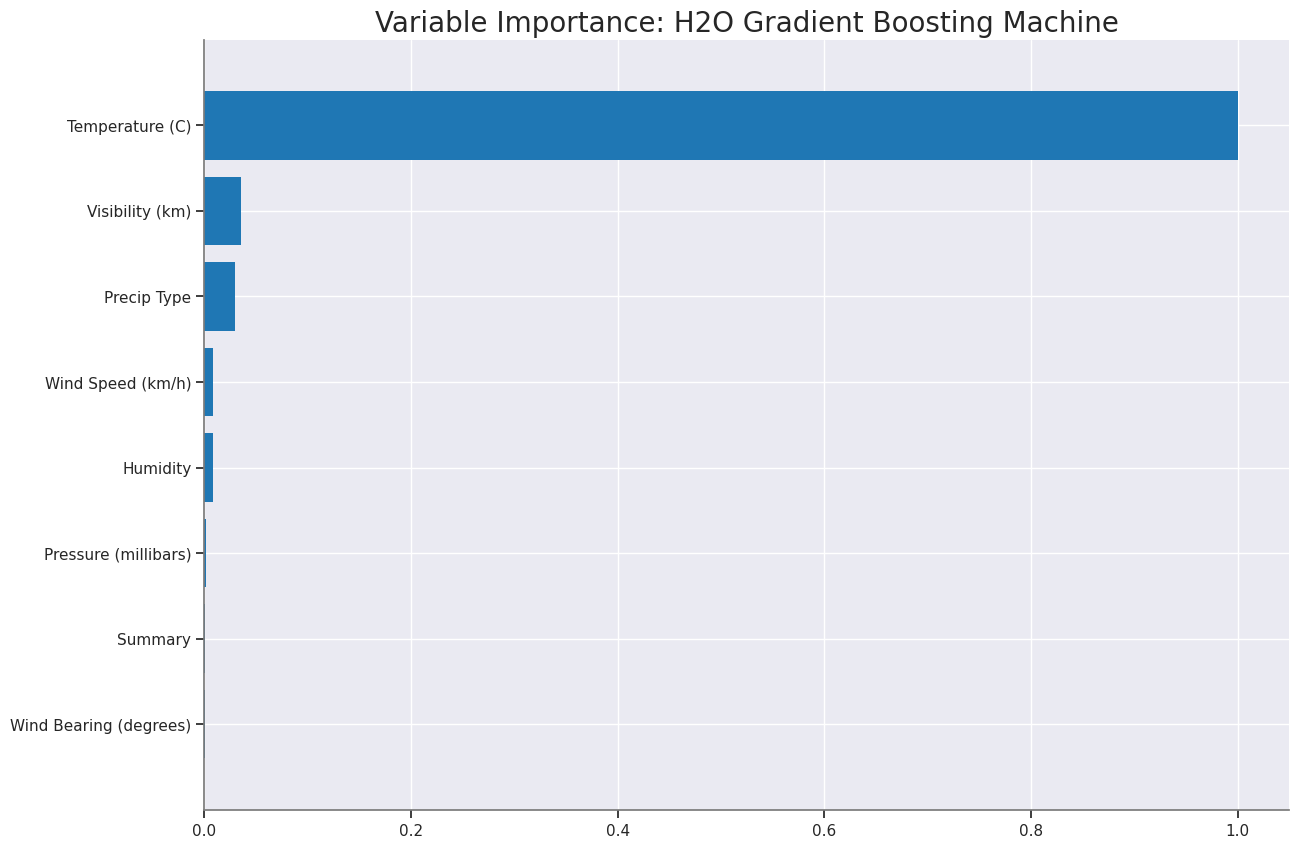

<Figure size 1600x800 with 0 Axes>

In [36]:
if best_model.algo in [
    "gbm",
    "drf",
    "xrt",
    "xgboost",
]:  # Importance of all the variables in GBM algorithm.
    best_model.varimp_plot()

The above graph is a variable importance graph on the h20 distributed Random forest model


*   We can interpret that temperature has the highest most importantance among other variables
*   precipitation type, humidity have the next significance relation but very low inthe scale of 1.0



<>:1: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:1: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<ipython-input-37-0cab54a0793b>:1: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if glm_index is not 0:


5
glm


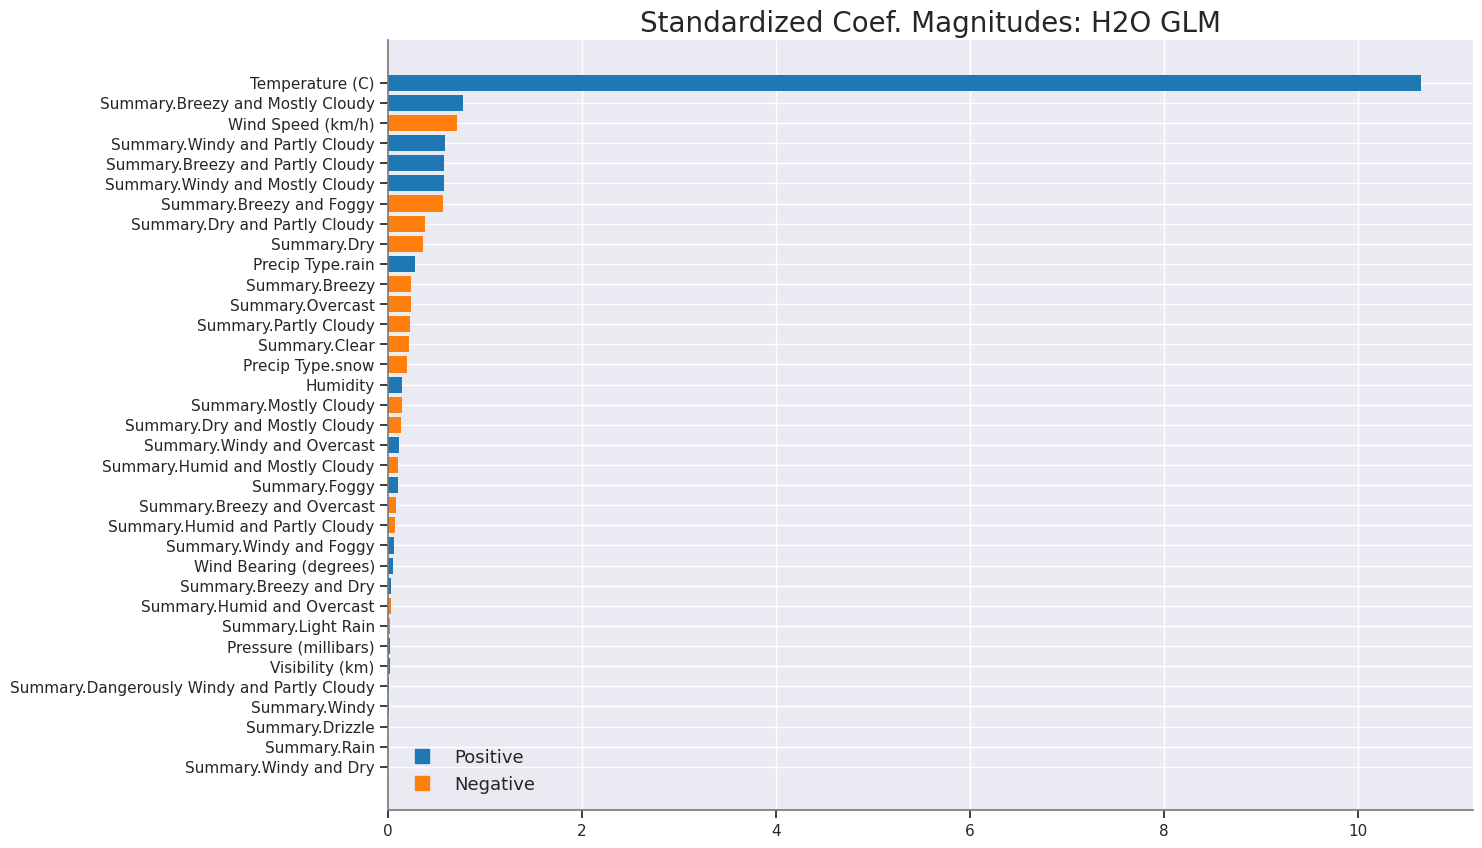

In [37]:
if glm_index is not 0:
    print(glm_index)
    glm_model = h2o.get_model(aml.leaderboard[glm_index, "model_id"])
    print(glm_model.algo)
    glm_model.std_coef_plot()

In [38]:
print(best_model.rmse(train=True))

0.14164498955994528


In [39]:
def model_performance_stats(perf):
    d = {}
    try:
        d["mse"] = perf.mse()
    except:
        pass
    try:
        d["rmse"] = perf.rmse()
    except:
        pass
    try:
        d["null_degrees_of_freedom"] = perf.null_degrees_of_freedom()
    except:
        pass
    try:
        d["residual_degrees_of_freedom"] = perf.residual_degrees_of_freedom()
    except:
        pass
    try:
        d["residual_deviance"] = perf.residual_deviance()
    except:
        pass
    try:
        d["null_deviance"] = perf.null_deviance()
    except:
        pass
    try:
        d["aic"] = perf.aic()
    except:
        pass
    try:
        d["logloss"] = perf.logloss()
    except:
        pass
    try:
        d["auc"] = perf.auc()
    except:
        pass
    try:
        d["gini"] = perf.gini()
    except:
        pass
    return d

In [40]:
mod_perf = best_model.model_performance(df_test)
stats_test = {}
stats_test = model_performance_stats(mod_perf)
stats_test

{'mse': 0.027318265525255556,
 'rmse': 0.16528238117009192,
 'null_degrees_of_freedom': None,
 'residual_degrees_of_freedom': None,
 'residual_deviance': None,
 'null_deviance': None}

In [41]:
predictions = best_model.predict(df_test)

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [42]:
y_pred = h2o.as_list(
    predictions
)  # Predictions on Test Dataset using the best model from the leaderboard.
print(y_pred)

Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
         predict
0       7.109016
1      13.684428
2      15.617989
3      11.247526
4      21.134011
...          ...
19114  28.621790
19115  28.720250
19116  27.580616
19117  28.127944
19118  30.061603

[19119 rows x 1 columns]


In [43]:
y_test = h2o.as_list(df_test[y])  # Real Answers
y_test

Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


Apparent Temperature (C)
0                      7.227778
1                     13.772222
2                     15.550000
3                     11.183333
4                     21.183333
...                         ...
19114                 28.405556
19115                 28.466667
19116                 27.600000
19117                 28.216667
19118                 29.972222

[19119 rows x 1 columns]

In [44]:
print(X)

['Summary', 'Precip Type', 'Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)', 'Pressure (millibars)']


**REGULARIZATION**

Regularization is a technique used in linear regression to prevent overfitting and enhance generalization by adding a penalty term to the loss function. Ridge and Lasso are two popular regularization techniques.

Ridge regularization adds a penalty term proportional to the square of coefficients, which shrinks them towards zero. It helps to avoid overfitting and reduces model variance, especially when dealing with correlated input variables.

Lasso regularization is similar, but uses a penalty term proportional to the absolute value of coefficients. Unlike Ridge, Lasso can set some coefficients to zero, making it an excellent technique for feature selection and leading to simpler models.

Both techniques differ in the penalty function they use. Ridge uses L2 regularization, which evenly distributes penalties across all coefficients, while Lasso uses L1 regularization, which concentrates penalties on vital coefficients.

The choice between Ridge and Lasso depends on the specific problem and input variable properties. If the input variables have high correlations, Ridge may be a better choice. But, if the goal is to find the most important features, Lasso may be a better choice.

In [45]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

weather_glm = H2OGeneralizedLinearEstimator(
    family="gaussian", lambda_=0, compute_p_values=True, nfolds=5
)  # Elastic Net Regularization
weather_glm_regularization_ridge = H2OGeneralizedLinearEstimator(
    family="gaussian", alpha=0, nfolds=5
)  # RIDGE Regularization
weather_glm_regularization_lasso = H2OGeneralizedLinearEstimator(
    family="gaussian", alpha=1, nfolds=5
)  # LASSO Regularization
weather_glm_regularization_lamba_search = H2OGeneralizedLinearEstimator(
    lambda_search=True
)  # Lambda Search

This code creates two generalized linear regression models using H2O. Each model uses a different regularization method: Ridge and Lasso. For Ridge regularization, the model has "alpha" set to 0, indicating Ridge. It uses a Gaussian error distribution for continuous response variables and 5-fold cross-validation to evaluate performance. For Lasso regularization, the model is similar but with "alpha" set to 1, indicating Lasso. Both models use H2O's ability to search for optimal lambda values for L1 and L2 regularization.

In [46]:
weather_glm.train(x=X, y=y, training_frame=df_train)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1708404175774_14


GLM Model: summary
    family    link      regularization    number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  --------  ----------------  ----------------------------  -----------------------------  ----------------------  ----------------
    gaussian  identity  None              33                            32                             1                       py_2_sid_8acb

ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 1.1297356510316054
RMSE: 1.0628902347051672
MAE: 0.8393139686377489
RMSLE: NaN
Mean Residual Deviance: 1.1297356510316054
R^2: 0.9901600573028766
Null degrees of freedom: 76792
Residual degrees of freedom: 76760
Null deviance: 8816696.653633073
Residual deviance: 86755.78984967008
AIC: 227364.58539412377

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 1.1326375139803875
RMSE: 1.064254440432544
MAE: 0.8400785074448388
RMSLE: NaN
Mean Residual Deviance: 1.1326375139803875
R^2: 0.9901347822174129
Null degrees of freedom: 76792
Residual degrees of freedom: 76762
Null deviance: 8816770.746994399
Residual deviance: 86978.63261109589
AIC: 227557.5846222627

Cross-Validation Metrics Summary: 
                        mean         sd           cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  -----------  -----------  ------------  ------------  ------------  ------------  ------------
mae                     0.840084     0.00242248   0.836486      0.842269      0.840806      0.83885       0.842011
mean_residual_deviance  1.13264      0.00969349   1.12056       1.13492       1.14401       1.12499       1.13871
mse                     1.13264      0.00969349   1.12056       1.13492       1.14401       1.12499       1.13871
null_deviance           1.76335e+06  18243.5      1.76612e+06   1.78857e+06   1.76888e+06   1.75354e+06   1.73967e+06
r2                      0.990134     0.000112863  0.990173      0.990237      0.989988      0.990231      0.990043
residual_deviance       17395.7      212.323      17356.3       17462         17709.2       17130.2       17320.9
rmse                    1.06425      0.00455553   1.05856       1.06533       1.06958       1.06066       1.0671
rmsle                   nan          0            nan           nan           nan           nan           nan

Scoring History: 
    timestamp            duration    iterations    negative_log_likelihood    objective           training_rmse       training_deviance    training_mae        training_r2
--  -------------------  ----------  ------------  -------------------------  ------------------  ------------------  -------------------  ------------------  ------------------
    2024-02-20 04:50:54  0.000 sec   0             8816696.654827934          114.81120225577766
    2024-02-20 04:50:54  0.512 sec   1                                                            1.0628902347051672  1.1297356510316054   0.8393139686377489  0.9901600573028766

Variable Importances: 
variable                                     relative_importance    scaled_importance      percentage
-------------------------------------------  ---------------------  ---------------------  ----------------------
Temperature (C)                              10.685201644897461     1.0                    0.2810274902976593
Summary.Breezy and Dry                       3.180590867996216      0.29766315823483347    0.0836515303128103
Summary.Windy and Mostly Cloudy              2.8810274600982666     0.2696278044948317     0.07577282521165049
Summary.Windy and Foggy                      2.302018165588379      0.21543984307377756    0.060544518409145265
Summary.Windy and Partly Cloudy              2.2578043937683105     0.21130199211977316    0.05938166854031564
Summary.Dangerously Windy and Partly Clo

Ridge Regularization

In [47]:
weather_glm_regularization_ridge.train(x=X, y=y, training_frame=df_train)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1708404175774_15


GLM Model: summary
    family    link      regularization              number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  --------  --------------------------  ----------------------------  -----------------------------  ----------------------  ----------------
    gaussian  identity  Ridge ( lambda = 0.01064 )  35                            34                             1                       py_2_sid_8acb

ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 1.1686614135958013
RMSE: 1.0810464437737175
MAE: 0.8572950973171439
RMSLE: NaN
Mean Residual Deviance: 1.1686614135958013
R^2: 0.9898210157999163
Null degrees of freedom: 76792
Residual degrees of freedom: 76758
Null deviance: 8816696.653633073
Residual deviance: 89745.01593426237
AIC: 229969.97397003093

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 1.185046250226185
RMSE: 1.0885982960790381
MAE: 0.8640764900482839
RMSLE: NaN
Mean Residual Deviance: 1.185046250226185
R^2: 0.9896783046679823
Null degrees of freedom: 76792
Residual degrees of freedom: 76759
Null deviance: 8816902.431182638
Residual deviance: 91003.25669361942
AIC: 231037.14760095644

Cross-Validation Metrics Summary: 
                        mean         sd           cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  -----------  -----------  ------------  ------------  ------------  ------------  ------------
mae                     0.864076     0.00461835   0.861126      0.860532      0.867735      0.870322      0.860662
mean_residual_deviance  1.18501      0.0153392    1.1776        1.17356       1.2066        1.19557       1.1717
mse                     1.18501      0.0153392    1.1776        1.17356       1.2066        1.19557       1.1717
null_deviance           1.76338e+06  20200.6      1.7603e+06    1.74552e+06   1.78771e+06   1.7429e+06    1.78048e+06
r2                      0.989678     0.000141217  0.989775      0.989744      0.989496      0.989559      0.989816
residual_deviance       18200.7      341.833      17999.6       17901.4       18777.2       18195.4       18129.7
rmse                    1.08856      0.00703465   1.08517       1.08331       1.09846       1.09342       1.08245
rmsle                   nan          0            nan           nan           nan           nan           nan

Scoring History: 
    timestamp            duration    iterations    negative_log_likelihood    objective           training_rmse       training_deviance    training_mae        training_r2
--  -------------------  ----------  ------------  -------------------------  ------------------  ------------------  -------------------  ------------------  ------------------
    2024-02-20 04:50:57  0.000 sec   0             8816696.654827934          114.81120225577766
    2024-02-20 04:50:57  0.279 sec   1                                                            1.0810464437737175  1.1686614135958013   0.8572950973171439  0.9898210157999163

Variable Importances: 
variable                                     relative_importance     scaled_importance       percentage
-------------------------------------------  ----------------------  ----------------------  ----------------------
Temperature (C)                              10.41195297241211       1.0                     0.7623385424218848
Wind Speed (km/h)                            0.7176221609115601      0.06892291607664748     0.05254259538133733
Precip Type.rain                             0.3785293996334076      0.03635527365868564     0.02771502633031115
Precip Type.snow                             0.3785293996334076      0.03635527365868564     0.02771502633031115
Summary.Breezy and Mostly Cloudy             0.30462443828582764     0.029257185380396133    0.022303880058258

Lasso Regularization

In [48]:
weather_glm_regularization_lasso.train(x=X, y=y, training_frame=df_train)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1708404175774_16


GLM Model: summary
    family    link      regularization             number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  --------  -------------------------  ----------------------------  -----------------------------  ----------------------  ----------------
    gaussian  identity  Lasso (lambda = 0.01064 )  35                            9                              1                       py_2_sid_8acb

ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 1.1512984953483334
RMSE: 1.0729857852498947
MAE: 0.8456138306164037
RMSLE: NaN
Mean Residual Deviance: 1.1512984953483334
R^2: 0.989972245975271
Null degrees of freedom: 76792
Residual degrees of freedom: 76783
Null deviance: 8816696.653633073
Residual deviance: 88411.66535328457
AIC: 228770.4924885509

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 1.1545835112055016
RMSE: 1.0745154774155194
MAE: 0.8470481115713303
RMSLE: NaN
Mean Residual Deviance: 1.1545835112055016
R^2: 0.9899436336465688
Null degrees of freedom: 76792
Residual degrees of freedom: 76784
Null deviance: 8816953.3811935
Residual deviance: 88663.93157600409
AIC: 228987.2950054754

Cross-Validation Metrics Summary: 
                        mean         sd           cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  -----------  -----------  ------------  ------------  ------------  ------------  ------------
mae                     0.847065     0.0055757    0.845108      0.838555      0.853121      0.850193      0.848349
mean_residual_deviance  1.15461      0.0106019    1.14829       1.14117       1.16875       1.16          1.15485
mse                     1.15461      0.0106019    1.14829       1.14117       1.16875       1.16          1.15485
null_deviance           1.76339e+06  6084.7       1.75773e+06   1.77127e+06   1.7577e+06    1.76792e+06   1.76234e+06
r2                      0.989943     8.16546e-05  0.989971      0.990032      0.98981       0.989943      0.989959
residual_deviance       17732.8      113.24       17628.5       17655.1       17908.7       17777         17694.6
rmse                    1.07452      0.00493266   1.07158       1.06826       1.08109       1.07703       1.07464
rmsle                   nan          0            nan           nan           nan           nan           nan

Scoring History: 
    timestamp            duration    iterations    negative_log_likelihood    objective           training_rmse       training_deviance    training_mae        training_r2
--  -------------------  ----------  ------------  -------------------------  ------------------  ------------------  -------------------  ------------------  -----------------
    2024-02-20 04:51:00  0.000 sec   0             8816696.654827934          114.81120225577766
    2024-02-20 04:51:00  0.250 sec   1                                                            1.0729857852498947  1.1512984953483334   0.8456138306164037  0.989972245975271

Variable Importances: 
variable                         relative_importance    scaled_importance      percentage
-------------------------------  ---------------------  ---------------------  ---------------------
Temperature (C)                  10.678860664367676     1.0                    0.8916747082637004
Wind Speed (km/h)                0.6641411185264587     0.06219213260666552    0.05545515169834585
Precip Type.snow                 0.3076537251472473     0.028809601961920936   0.02568879342458918
Humidity                         0.15066711604595184    0.014108912999369418   0.012580560882630657
Summary.Foggy                    0.06693892925977707    0.006268358710132183   0.00558933692414934
Wind Bearing (degrees)           0.045343365520238876   0.004246086445489153   0.003786127892543993
S

Which Regularization helps:

For Lasso Regularization:

Train Data Metrics:
MSE: 1.1527
RMSE: 1.0737
MAE: 0.8448
R^2: 0.9900
Cross-Validation Metrics:
MSE: 1.1562
RMSE: 1.0753
MAE: 0.8463
R^2: 0.9899

For Ridge Regularization:

Train Data Metrics:
MSE: 1.1699
RMSE: 1.0816
MAE: 0.8568
R^2: 0.9898
Cross-Validation Metrics:
MSE: 1.1862
RMSE: 1.0891
MAE: 0.8636
R^2: 0.9897


Based on the metrics, Lasso regularization is the superior choice over Ridge regularization. It achieves significantly lower values of MSE, RMSE, and MAE on both the train data and cross-validation data. Furthermore, it demonstrates a higher R^2 value, indicating superior explanatory power. Therefore, it is safe to conclude that Lasso regularization is the better choice for this specific dataset and task.

In [49]:
lambda_search = weather_glm_regularization_lamba_search.train(
    x=X, y=y, training_frame=df_train
)

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


In [50]:
lambda_search

Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_model_python_1708404175774_17


GLM Model: summary
    family    link      regularization                                 lambda_search                                                                 number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  --------  ---------------------------------------------  ----------------------------------------------------------------------------  ----------------------------  -----------------------------  ----------------------  ----------------
    gaussian  identity  Elastic Net (alpha = 0.5, lambda = 0.002127 )  nlambda = 100, lambda.max = 21.272, lambda.min = 0.002127, lambda.1se = -1.0  35                            14                             100                     py_2_sid_8acb

ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 1.13876615880399
RMSE: 1.0671298696990867
MAE: 0.8420324463592127
RMSLE: NaN
Mean Residual Deviance: 1.13876615880399
R^2: 0.990081402018408
Null degrees of freedom: 76792
Residual degrees of freedom: 76778
Null deviance: 8816696.653633073
Residual deviance: 87449.2696330348
AIC: 227939.98754824678

Scoring History: 
     timestamp            duration    iteration    lambda    predictors    deviance_train      alpha    iterations    training_rmse       training_deviance    training_mae        training_r2
---  -------------------  ----------  -----------  --------  ------------  ------------------  -------  ------------  ------------------  -------------------  ------------------  -----------------
     2024-02-20 04:51:01  0.000 sec   1            .21E2     1             114.8112022557767   0.5
     2024-02-20 04:51:01  0.055 sec   2            .19E2     2             112.9389807233562   0.5
     2024-02-20 04:51:01  0.070 sec   3            .18E2     2             110.93721818619704  0.5
     2024-02-20 04:51:01  0.078 sec   4            .16E2     2             108.80184202972879  0.5
     2024-02-20 04:51:01  0.092 sec   5            .15E2     2             106.52953818149693  0.5
     2024-02-20 04:51:01  0.146 sec   6            .13E2     2             104.11792135898412  0.5
     2024-02-20 04:51:01  0.156 sec   7            .12E2     2             101.56571402412389  0.5
     2024-02-20 04:51:01  0.173 sec   8            .11E2     3             98.21780863487785   0.5
     2024-02-20 04:51:01  0.187 sec   9            .1E2      3             94.71430677409866   0.5
     2024-02-20 04:51:01  0.201 sec   10           .92E1     3             91.10960548079946   0.5
---  ---                  ---         ---          ---       ---           ---                 ---      ---           ---                 ---                  ---                 ---
     2024-02-20 04:51:02  1.720 sec   91           .49E-2    14            1.1436462816546957  0.5
     2024-02-20 04:51:02  1.734 sec   92           .45E-2    14            1.1427803594349946  0.5
     2024-02-20 04:51:02  1.743 sec   93           .41E-2    14            1.1420181966402563  0.5
     2024-02-20 04:51:02  1.758 sec   94           .37E-2    14            1.1413484124851394  0.5
     2024-02-20 04:51:02  1.766 sec   95           .34E-2    14            1.1407607335364376  0.5
     2024-02-20 04:51:02  1.774 sec   96           .31E-2    14            1.140247962680864   0.5
     2024-02-20 04:51:02  1.787 sec   97           .28E-2    14            1.139798574413556   0.5
     2024-02-20 04:51:02  1.791 sec   98           .26E-2    14            1.1394069682206507  0.5
     2024-02-20 04:51:02  1.855 sec   99           .23E-2    14            1.1390665386292667  0.5
     2024-02-20 04:51:02  1.862 sec   100          .21E-2    15            1.1387661543823926  0.5      100           1.0671298696990867  1.13876615880399     0.8420324463592127  0.990081402018408
[100 rows x 13 columns]


Variable Importances: 
variable     

In [51]:
coeff_table = weather_glm._model_json["output"]["coefficients_table"]

In [52]:
coeff_table.as_data_frame()  # Z-Value and P-Value showing the significance of each attributes.

names  coefficients  std_error  \
0                                     Intercept     -2.691530   0.167792   
1                        Summary.Breezy and Dry      3.180591   1.075558   
2                      Summary.Breezy and Foggy     -1.334457   0.249074   
3              Summary.Breezy and Mostly Cloudy      1.617237   0.170868   
4                   Summary.Breezy and Overcast      0.600070   0.170899   
5              Summary.Breezy and Partly Cloudy      1.431370   0.173158   
6                                 Summary.Clear      0.430291   0.163700   
7   Summary.Dangerously Windy and Partly Cloudy      2.031841   1.075732   
8                               Summary.Drizzle      0.646850   0.256310   
9                                   Summary.Dry     -0.656618   0.251479   
10                Summary.Dry and Mostly Cloudy     -0.476224   0.359904   
11                Summary.Dry and Partly Cloudy     -0.179416   0.207836   
12                                Summary.Foggy      0.750186   0.164445   
13              Summary.Humid and Mostly Cloudy      0.284171   0.244959   
14                   Summary.Humid and Overcast      0.232046   0.463841   
15              Summary.Humid and Partly Cloudy      0.169544   0.312085   
16                           Summary.Light Rain      0.589989   0.227560   
17                        Summary.Mostly Cloudy      0.516012   0.163448   
18                             Summary.Overcast      0.427372   0.163513   
19                        Summary.Partly Cloudy      0.419916   0.163528   
20                                 Summary.Rain      0.641507   0.390523   
21                                Summary.Windy      0.791391   0.409676   
22                        Summary.Windy and Dry      0.000000        NaN   
23                      Summary.Windy and Foggy      2.302018   0.635287   
24              Summary.Windy and Mostly Cloudy      2.881028   0.253420   
25                   Summary.Windy and Overcast      1.088835   0.242659   
26              Summary.Windy and Partly Cloudy      2.257804   0.220659   
27                             Precip Type.snow     -0.433070   0.015430   
28                              Temperature (C)      1.116528   0.000646   
29                                     Humidity      0.796708   0.028596   
30                            Wind Speed (km/h)     -0.103692   0.000679   
31                       Wind Bearing (degrees)      0.000505   0.000036   
32                              Visibility (km)      0.003961   0.001236   
33                         Pressure (millibars)      0.000185   0.000034   

        z_value        p_value  standardized_coefficients  
0    -16.040874   8.224859e-58                  10.418717  
1      2.957153   3.105882e-03                   3.180591  
2     -5.357680   8.453920e-08                  -1.334457  
3      9.464815   3.020392e-21                   1.617237  
4      3.511251   4.462596e-04                   0.600070  
5      8.266242   1.404275e-16                   1.431370  
6      2.628537   8.577005e-03                   0.430291  
7      1.888799   5.892256e-02                   2.031841  
8      2.523705   1.161452e-02                   0.646850  
9     -2.611028   9.028815e-03                  -0.656618  
10    -1.323197   1.857739e-01                  -0.476224  
11    -0.863259   3.879979e-01                  -0.179416  
12     4.561922   5.076572e-06                   0.750186  
13     1.160077   2.460209e-01                   0.284171  
14     0.500270   6.168861e-01                   0.232046  
15     0.543263   5.869500e-01                   0.169544  
16     2.592675   9.525089e-03                   0.589989  
17     3.157048   1.594365e-03                   0.516012  
18     2.613693   8.958703e-03                   0.427372  
19     2.567855   1.023487e-02                   0.419916  
20     1.642687   1.004518e-01                   0.641507  
21     1.931748   5.339430e-02                   0.791391  
2

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id                                                     rmse          mse        mae    rmsle    mean_residual_deviance    training_time_ms    predict_time_per_row_ms  algo
------------------------------------------------------  ---------  -----------  ---------  -------  ------------------------  ------------------  -------------------------  ---------------
GBM_1_AutoML_1_20240220_44658                            0.165282    0.0273183  0.0799741      nan                 0.0273183               11893                   0.030084  GBM
StackedEnsemble_BestOfFamily_1_AutoML_1_20240220_44658   0.166321    0.0276627  0.084523       nan                 0.0276627                2223                   0.043125  StackedEnsemble
StackedEnsemble_AllModels_1_AutoML_1_20240220_44658      0.166321    0.0276627  0.084523       nan                 0.0276627                1683                   0.035782  StackedEnsemble
StackedEnsemble_BestOfFamily_2_AutoML_1_20240220_44658   0.166321    0.0276627  0.084523       nan                 0.0276627                1727                   0.033403  StackedEnsemble
GLM_1_AutoML_1_20240220_44658                            1.06251     1.12894    0.838512       nan                 1.12894                   718                   0.000459  GLM
XGBoost_1_AutoML_1_20240220_44658                        1.06865     1.142      0.772444       nan                 1.142                   10783                   0.004043  XGBoost
XRT_1_AutoML_1_20240220_44658                            1.69303     2.86634    0.909281       nan                 2.86634                  1082                   0.00193   DRF
DRF_1_AutoML_1_20240220_44658                            1.95959     3.84       0.954677       nan                 3.84                      635                   0.000884  DRF
GBM_3_AutoML_1_20240220_44658                            4.39647    19.3289     3.73417        nan                19.3289                   1221                   0.003871  GBM
GBM_2_AutoML_1_20240220_44658                            4.5478     20.6825     3.84146        nan                20.6825                    600                   0.005073  GBM
GBM_4_AutoML_1_20240220_44658                            6.33425    40.1227     5.32351        nan                40.1227                    534                   0.001901  GBM
XGBoost_2_AutoML_1_20240220_44658                        7.93673    62.9917     6.44375        nan                62.9917                   1852                   0.000531  XGBoost
XGBoost_3_AutoML_1_20240220_44658                       11.3558    128.955      9.22829        nan               128.955                     398                   0.000492  XGBoost
[13 rows x 9 columns]

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

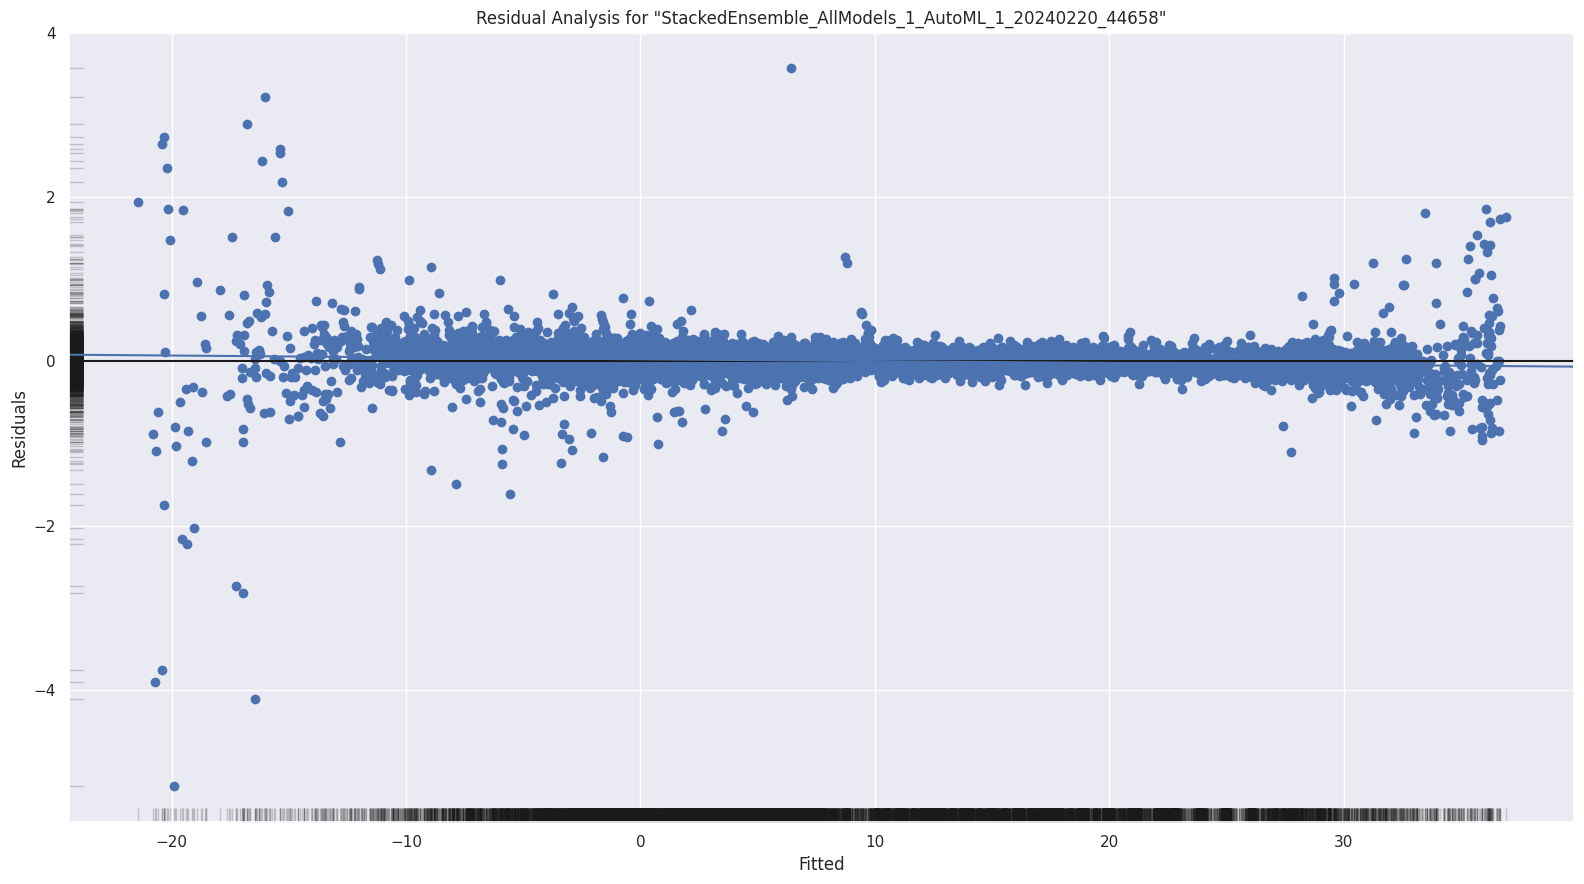

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

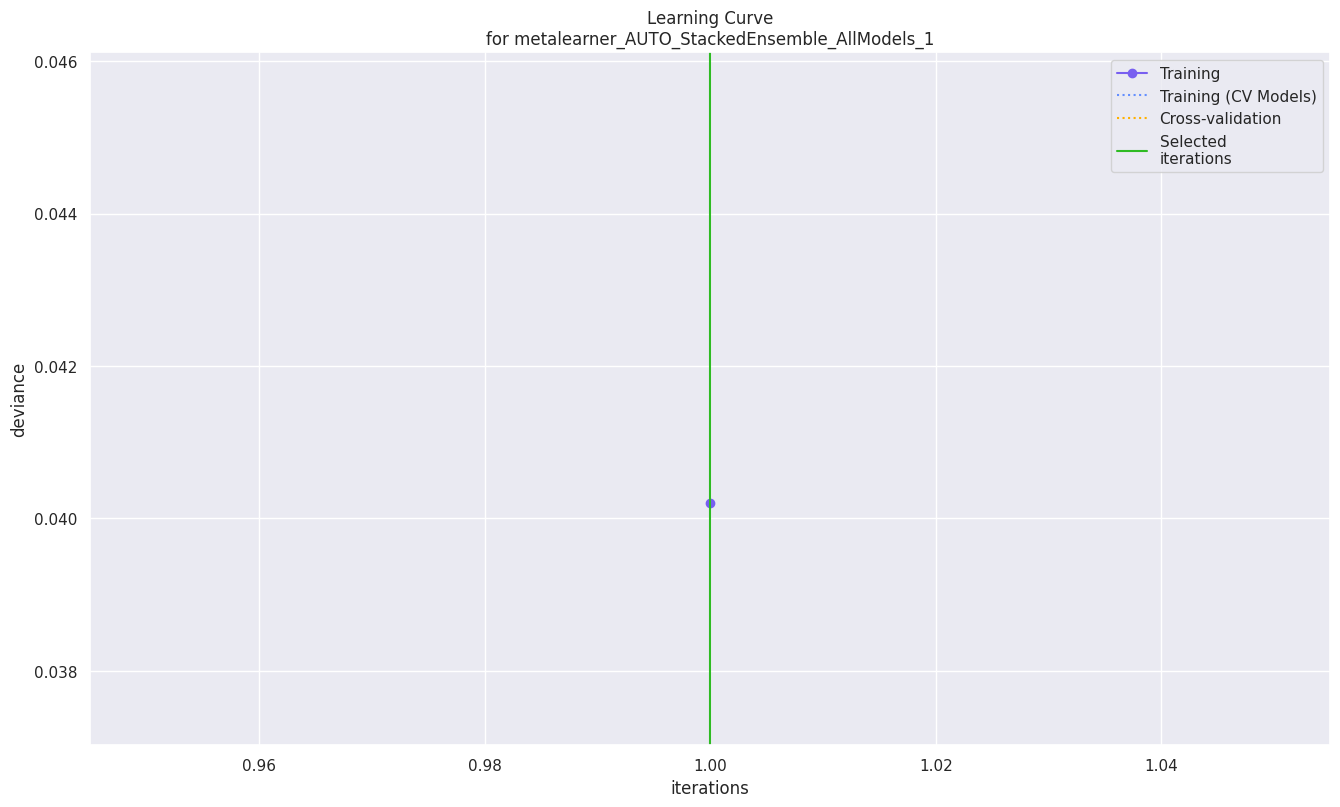

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

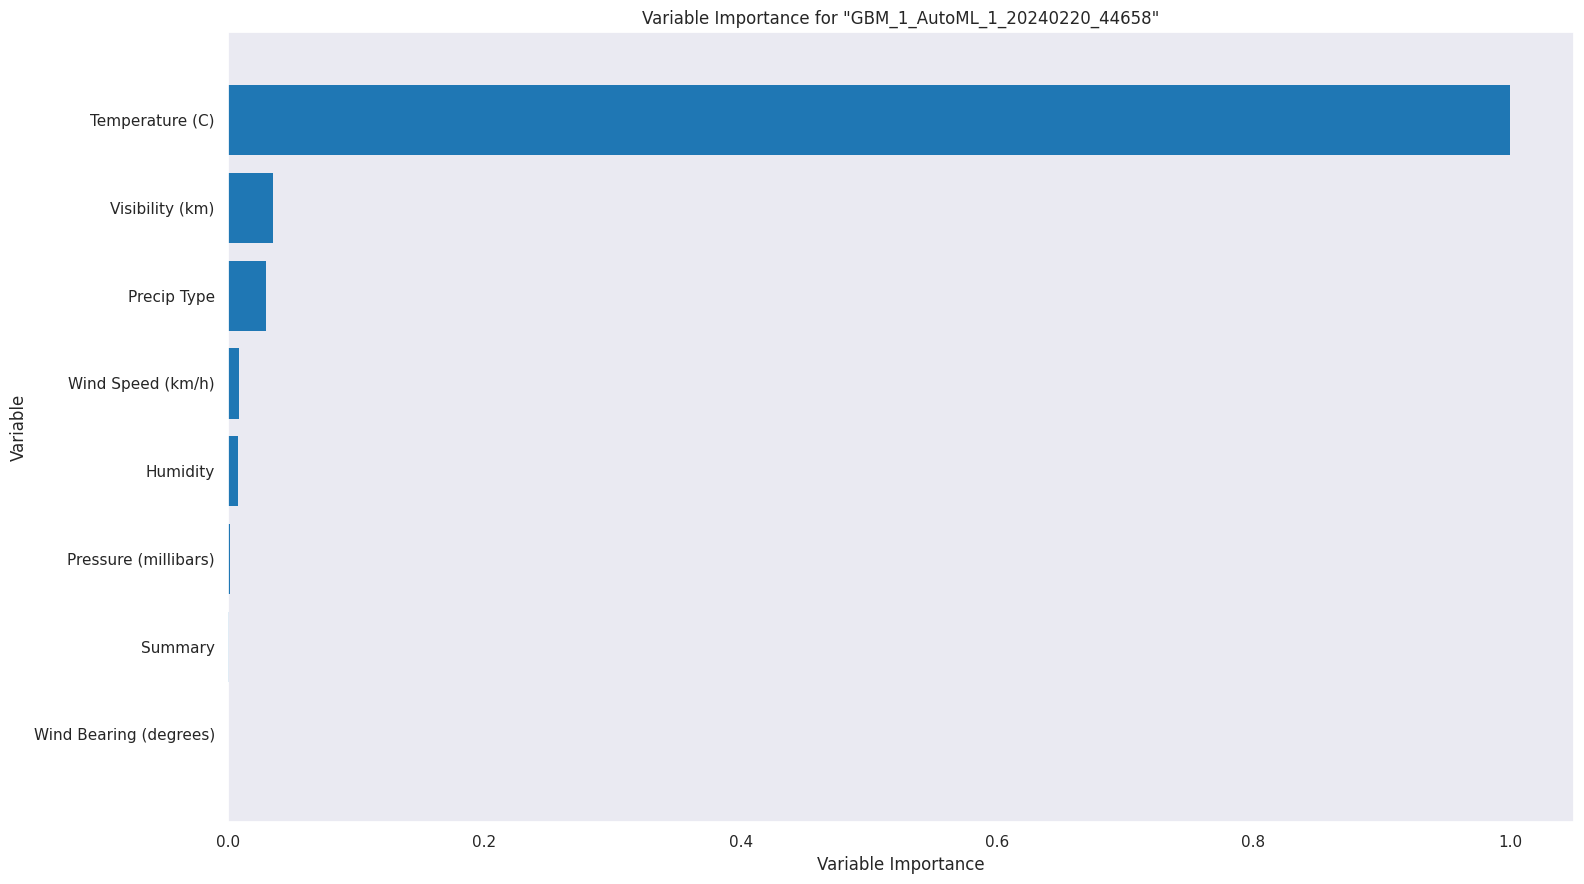

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

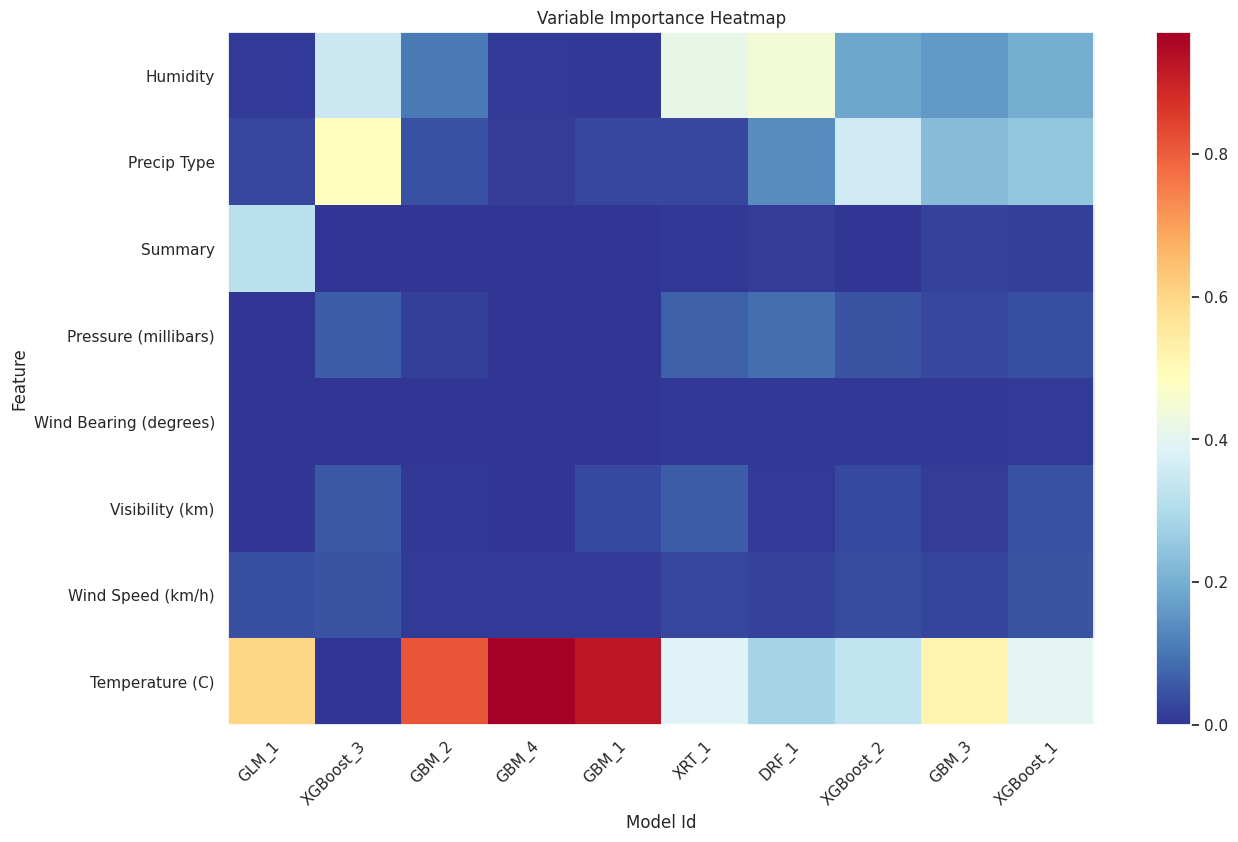

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

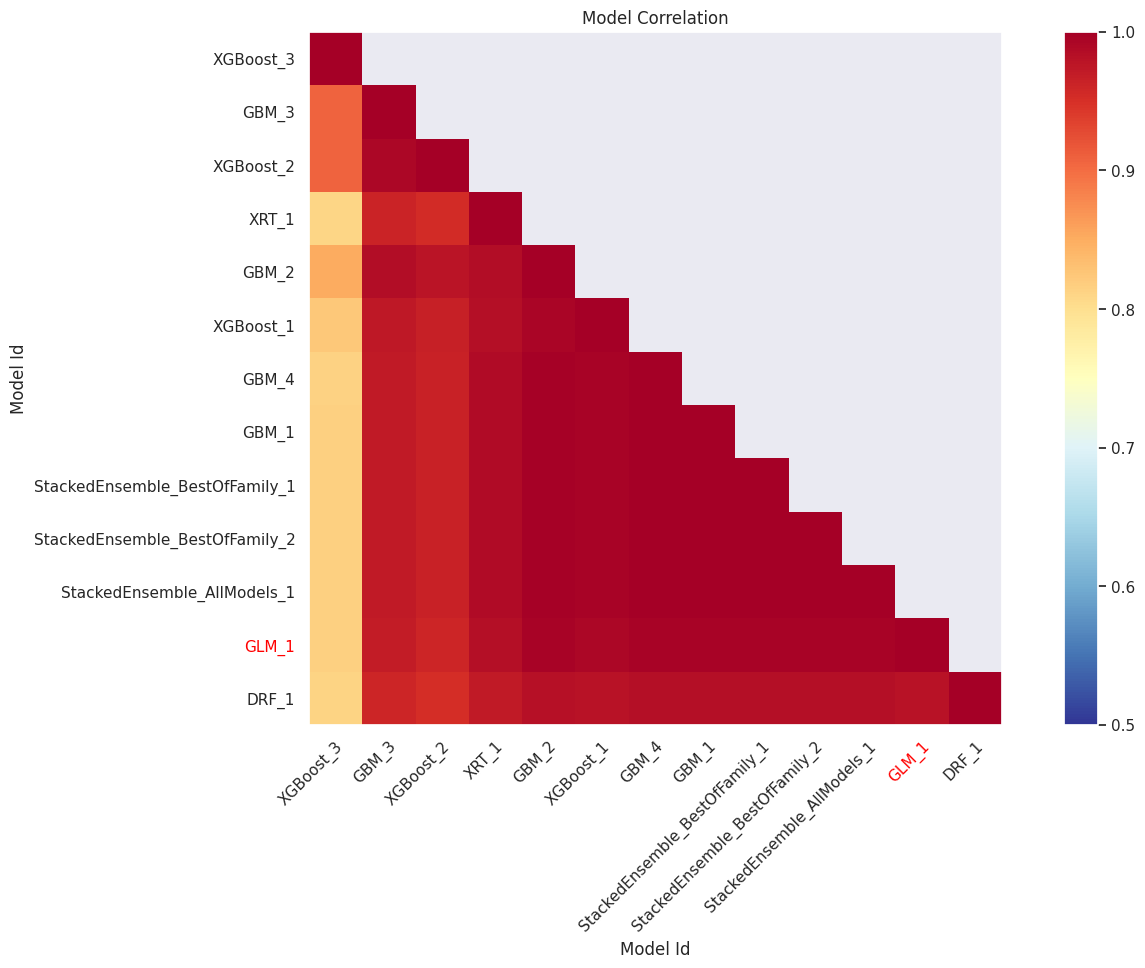

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

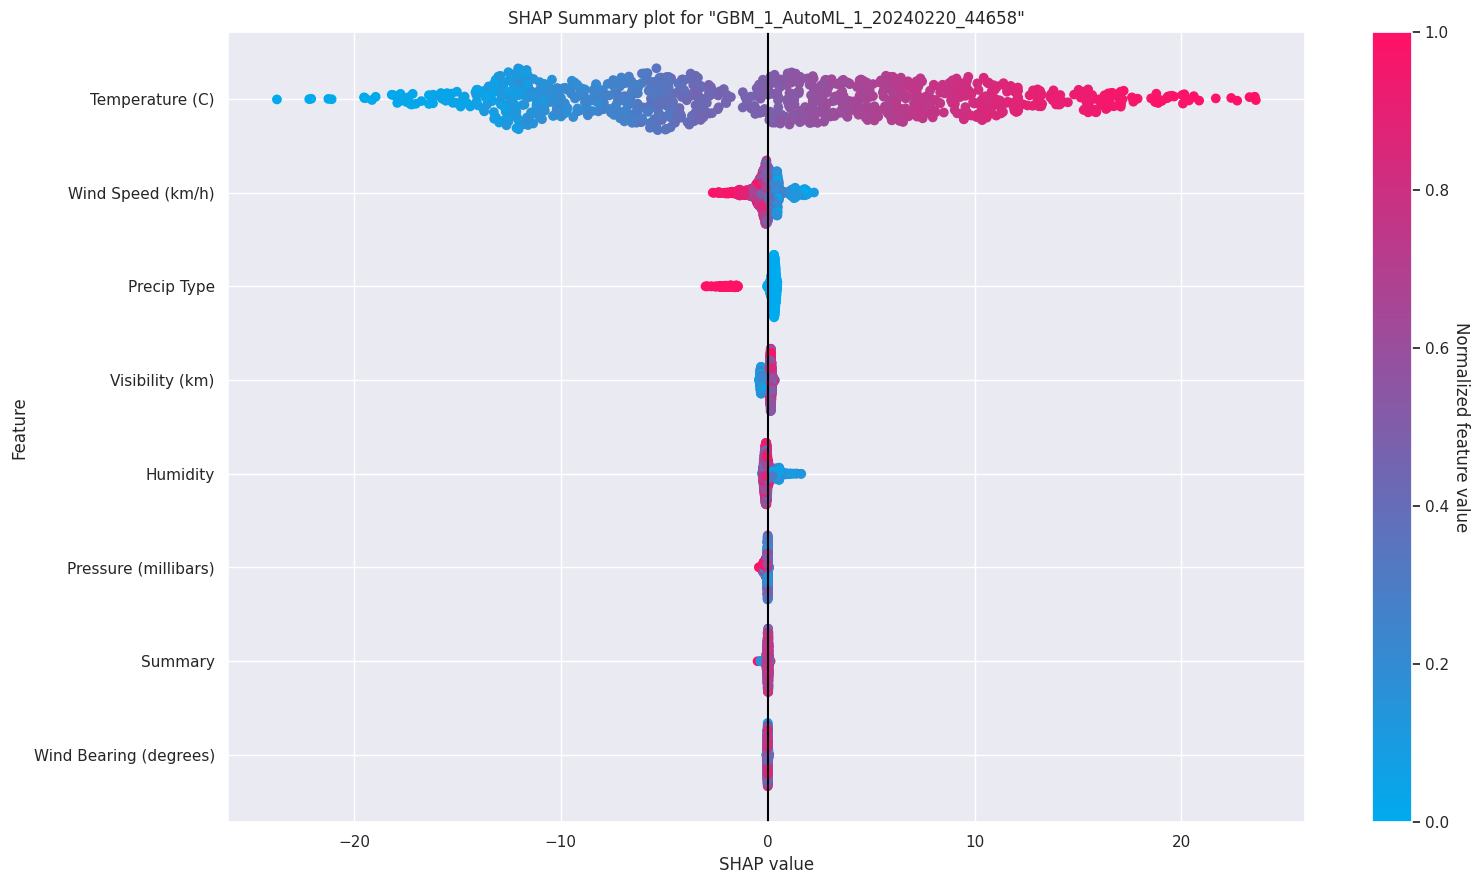

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

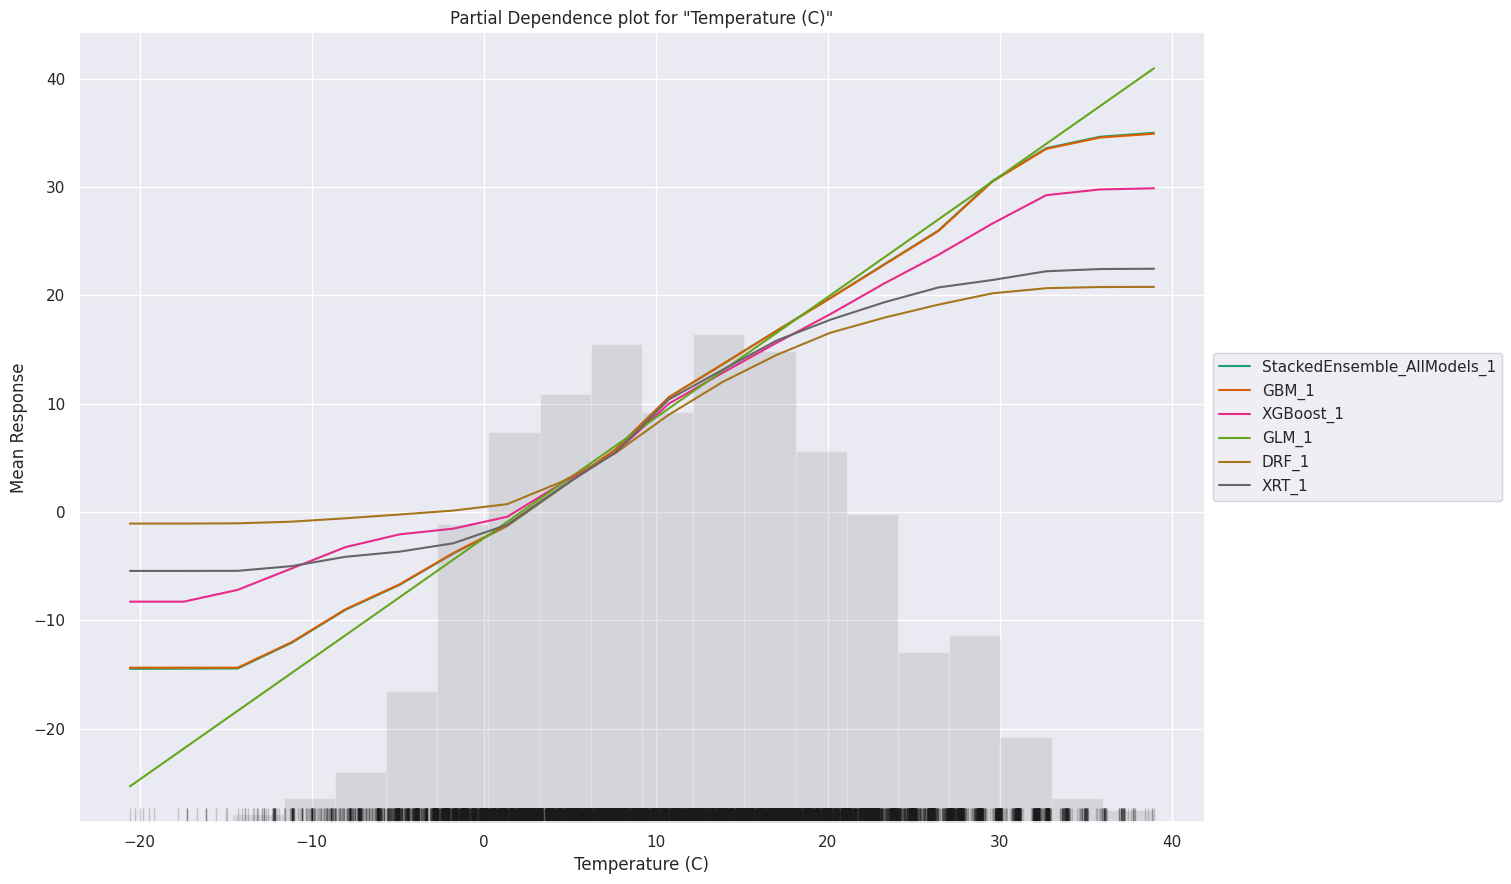

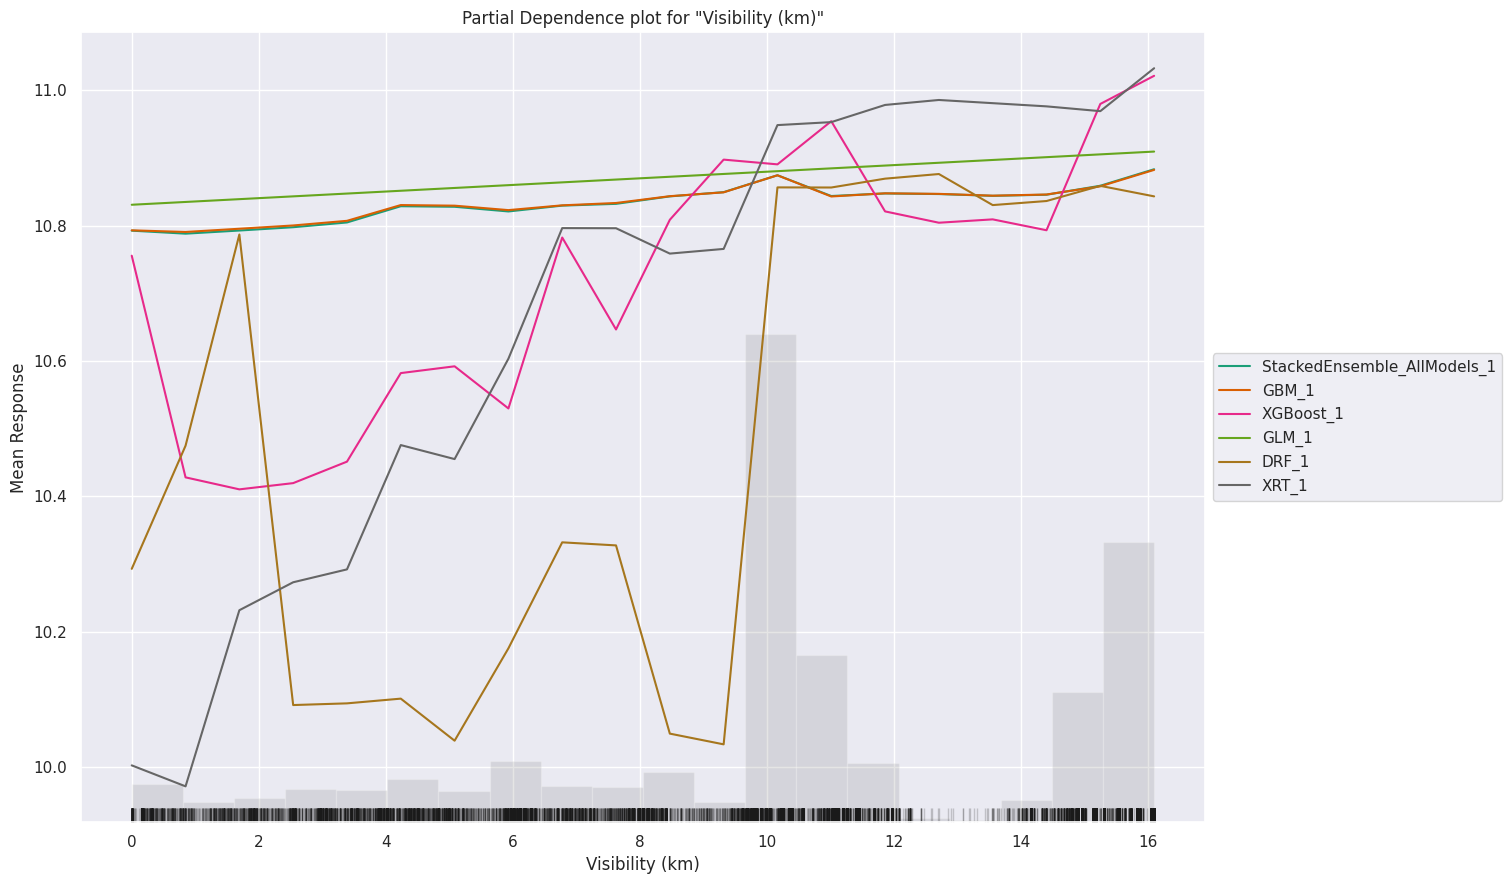

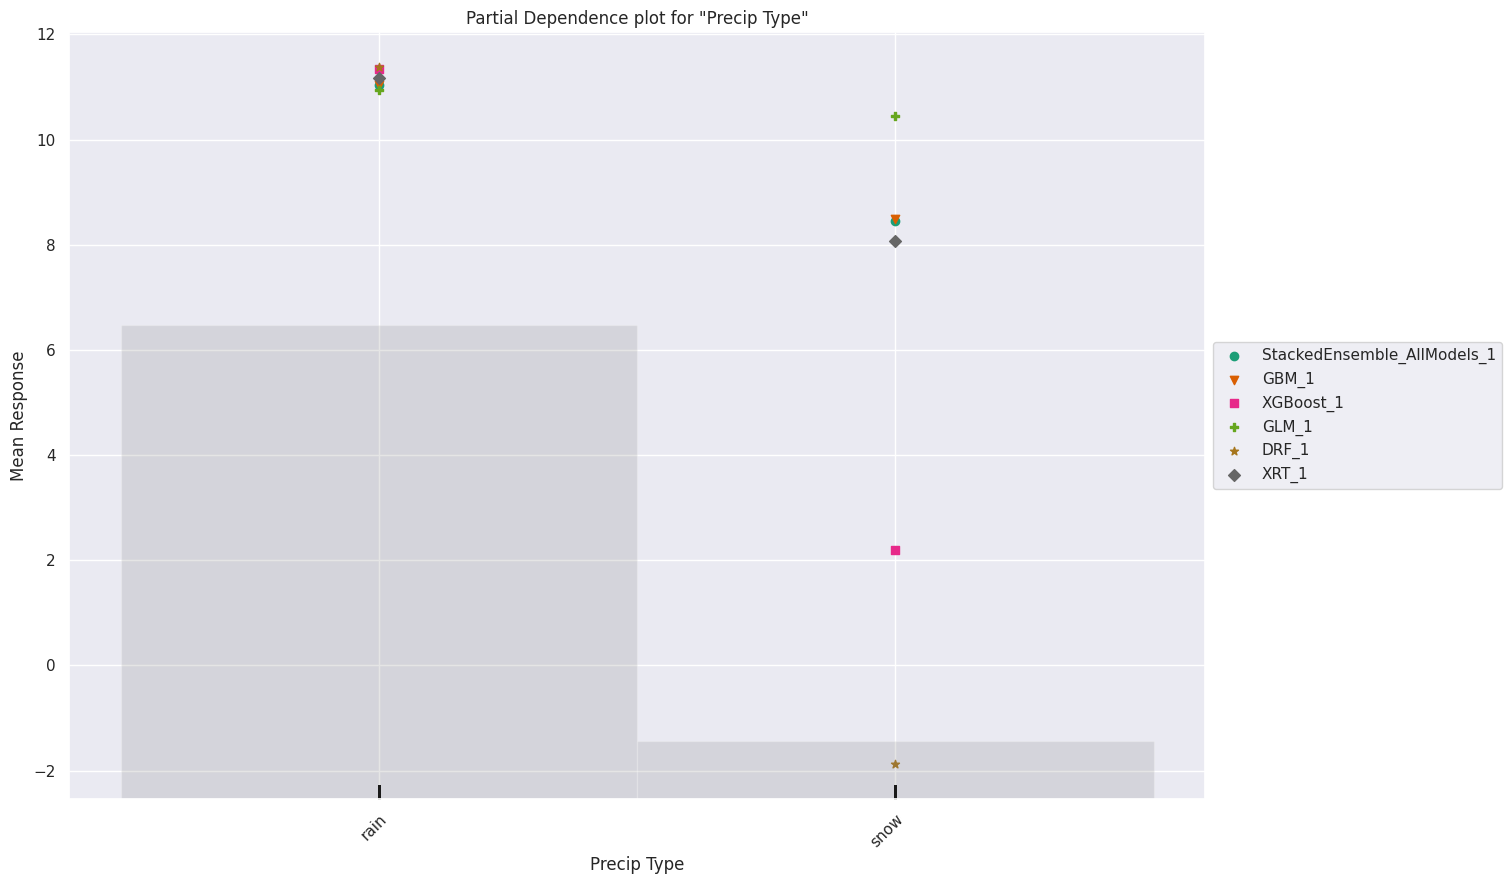

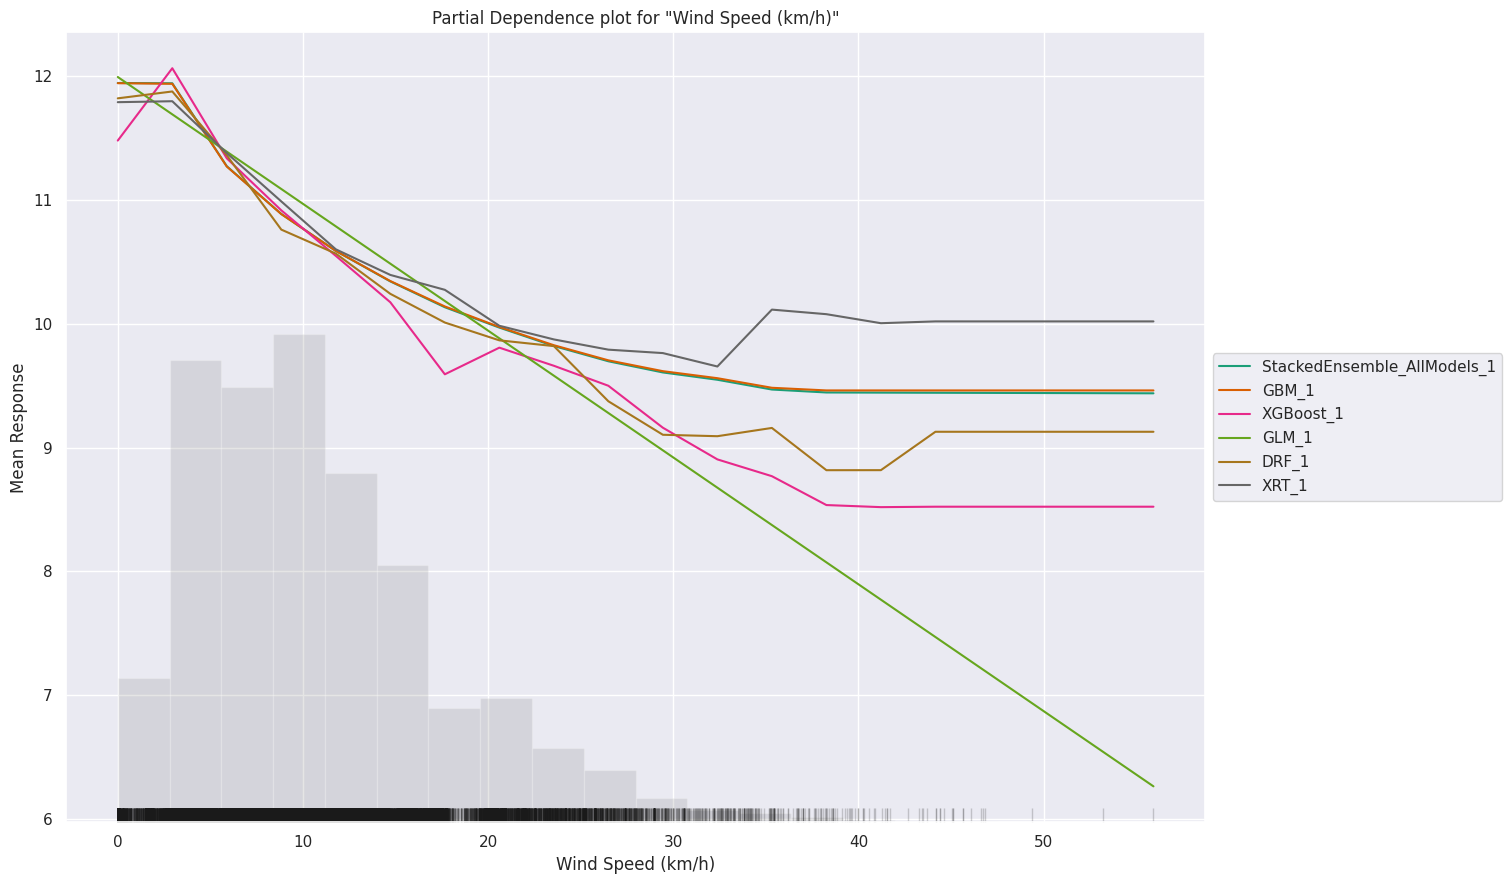

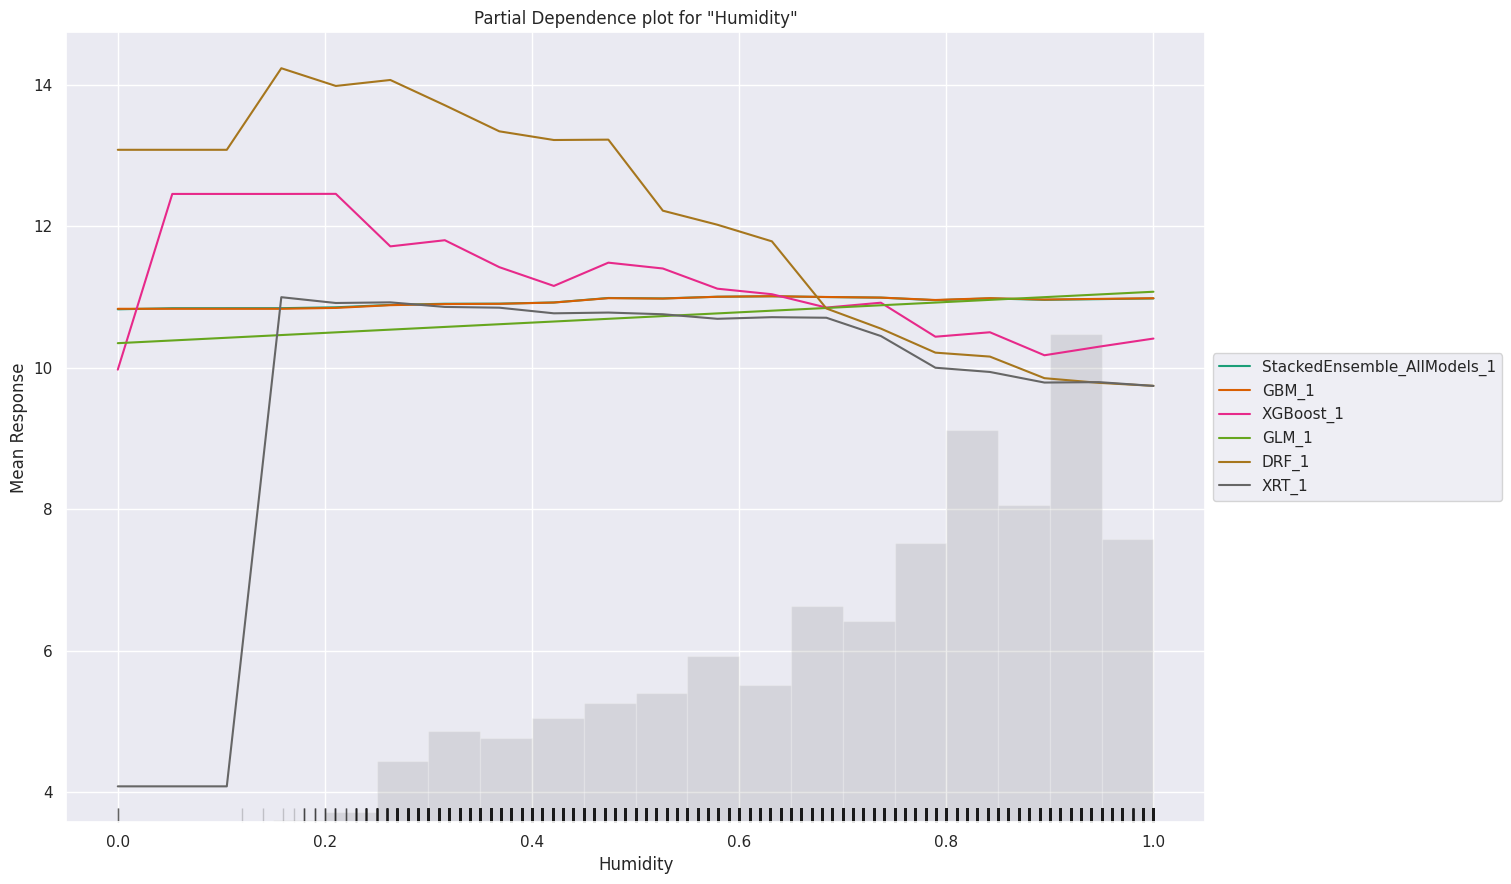

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

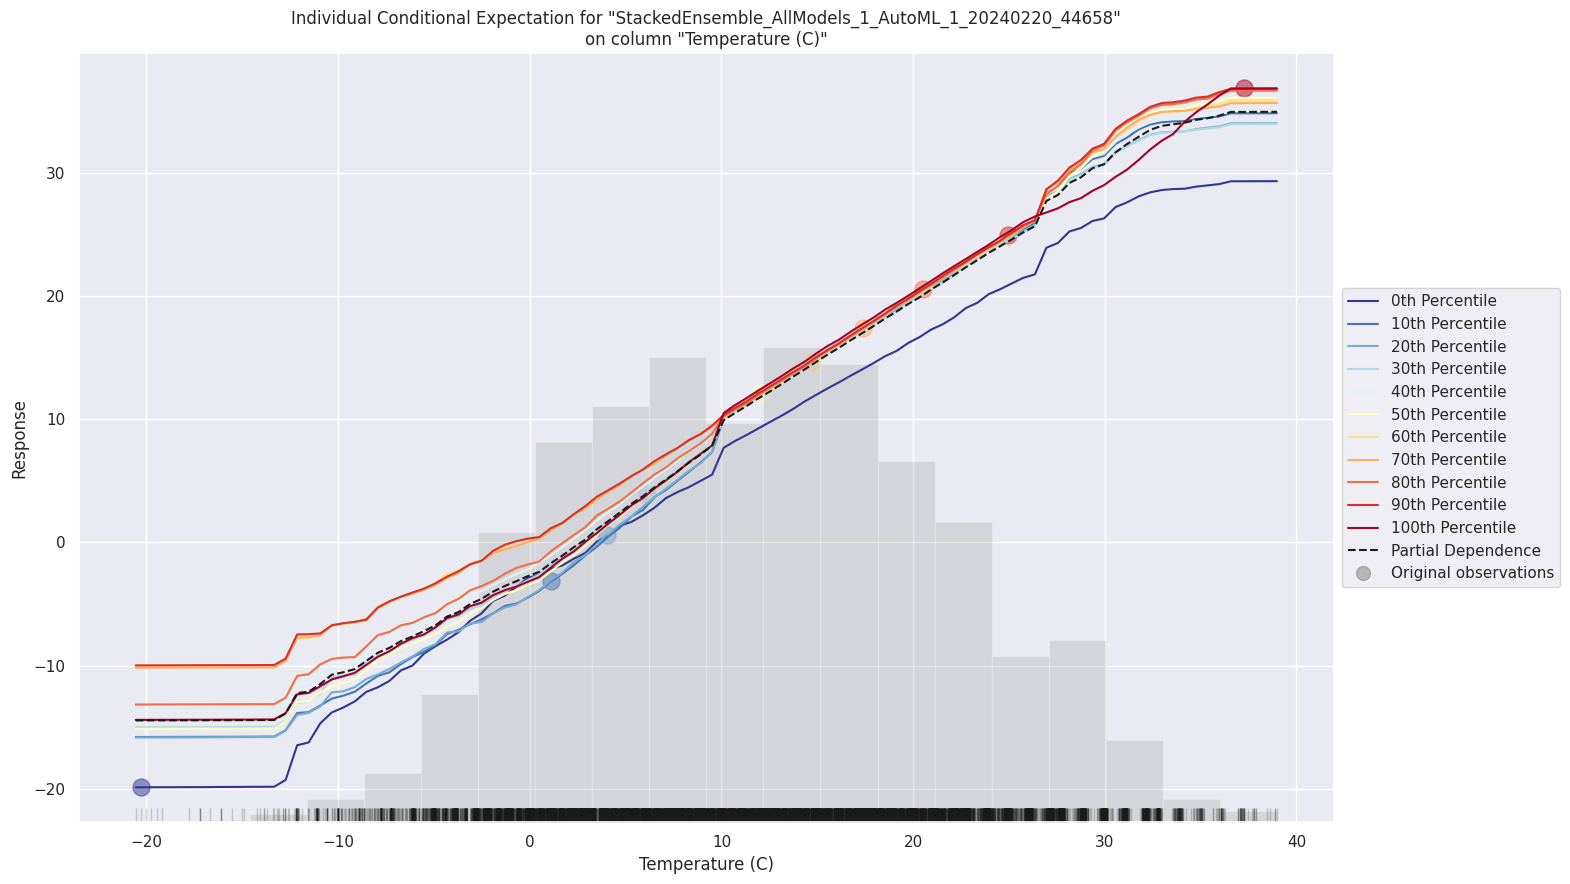

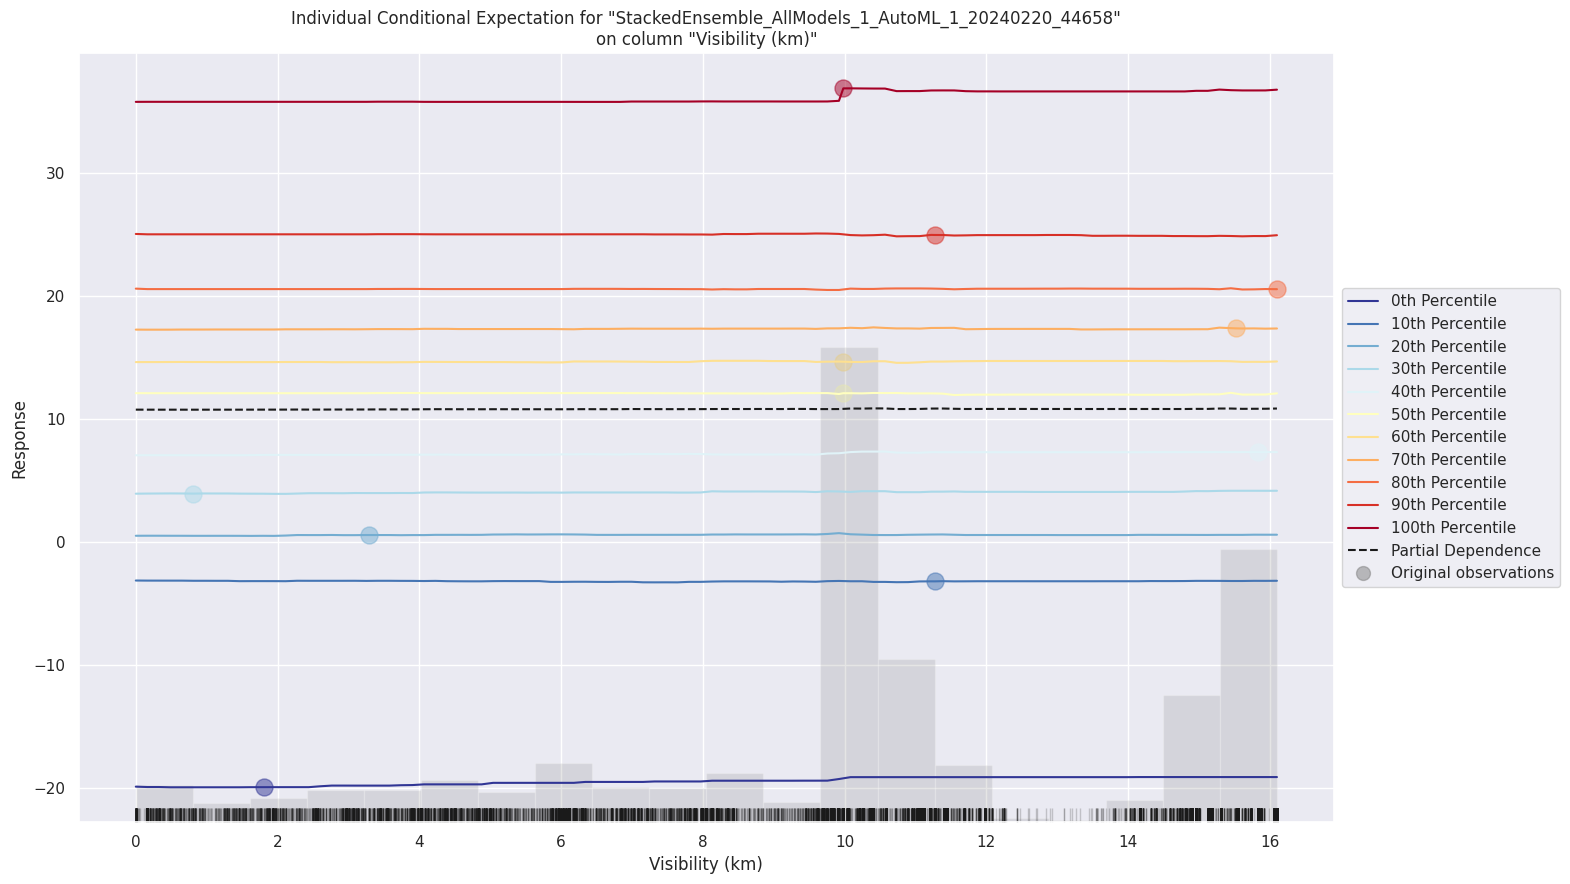

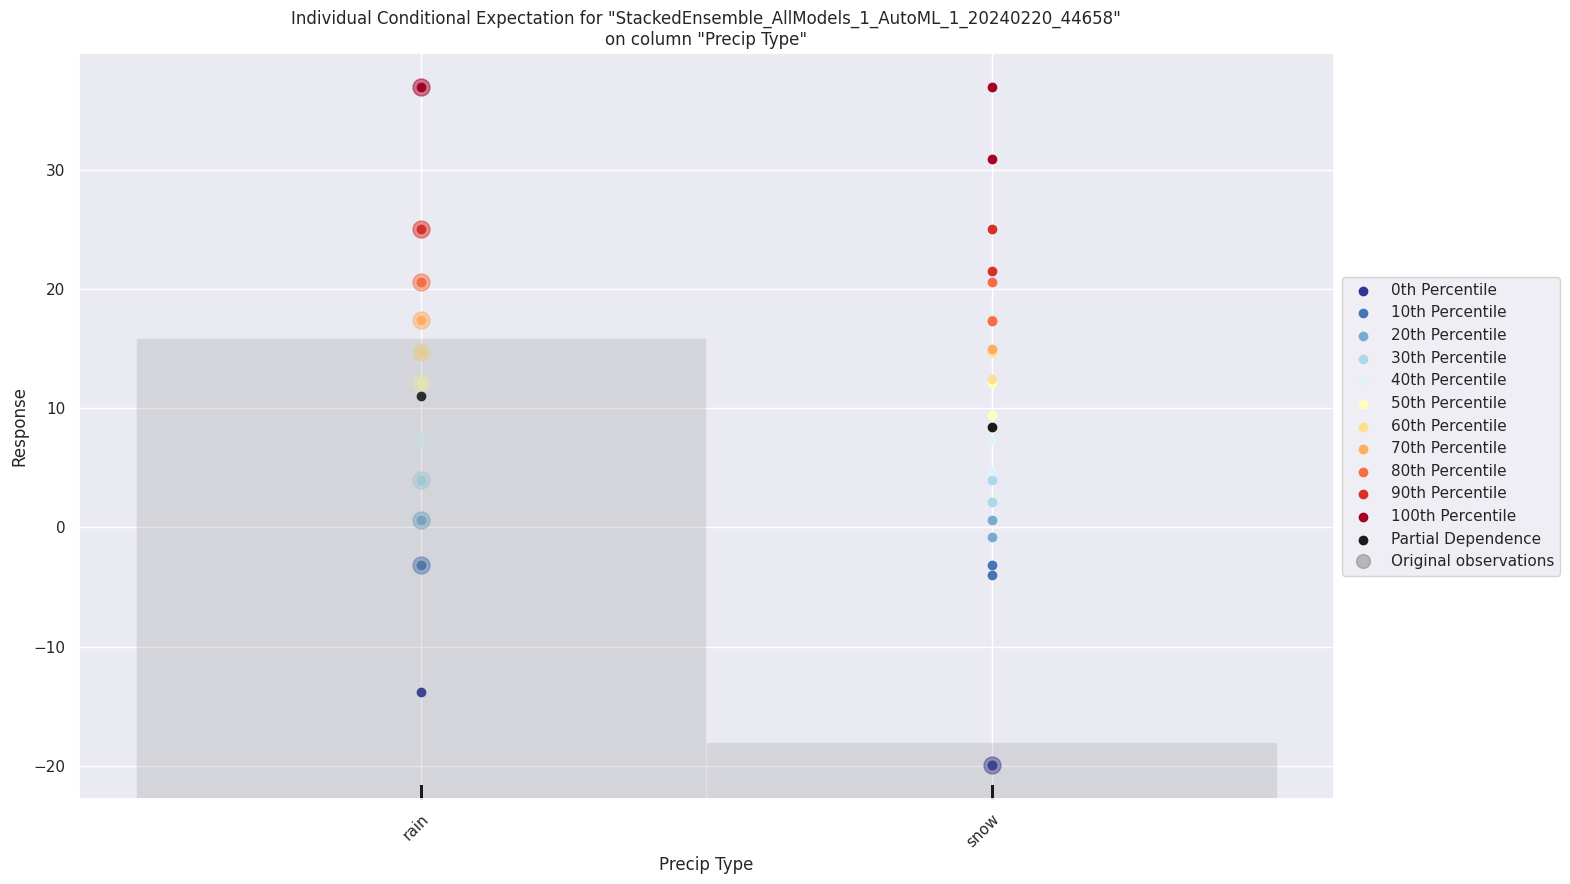

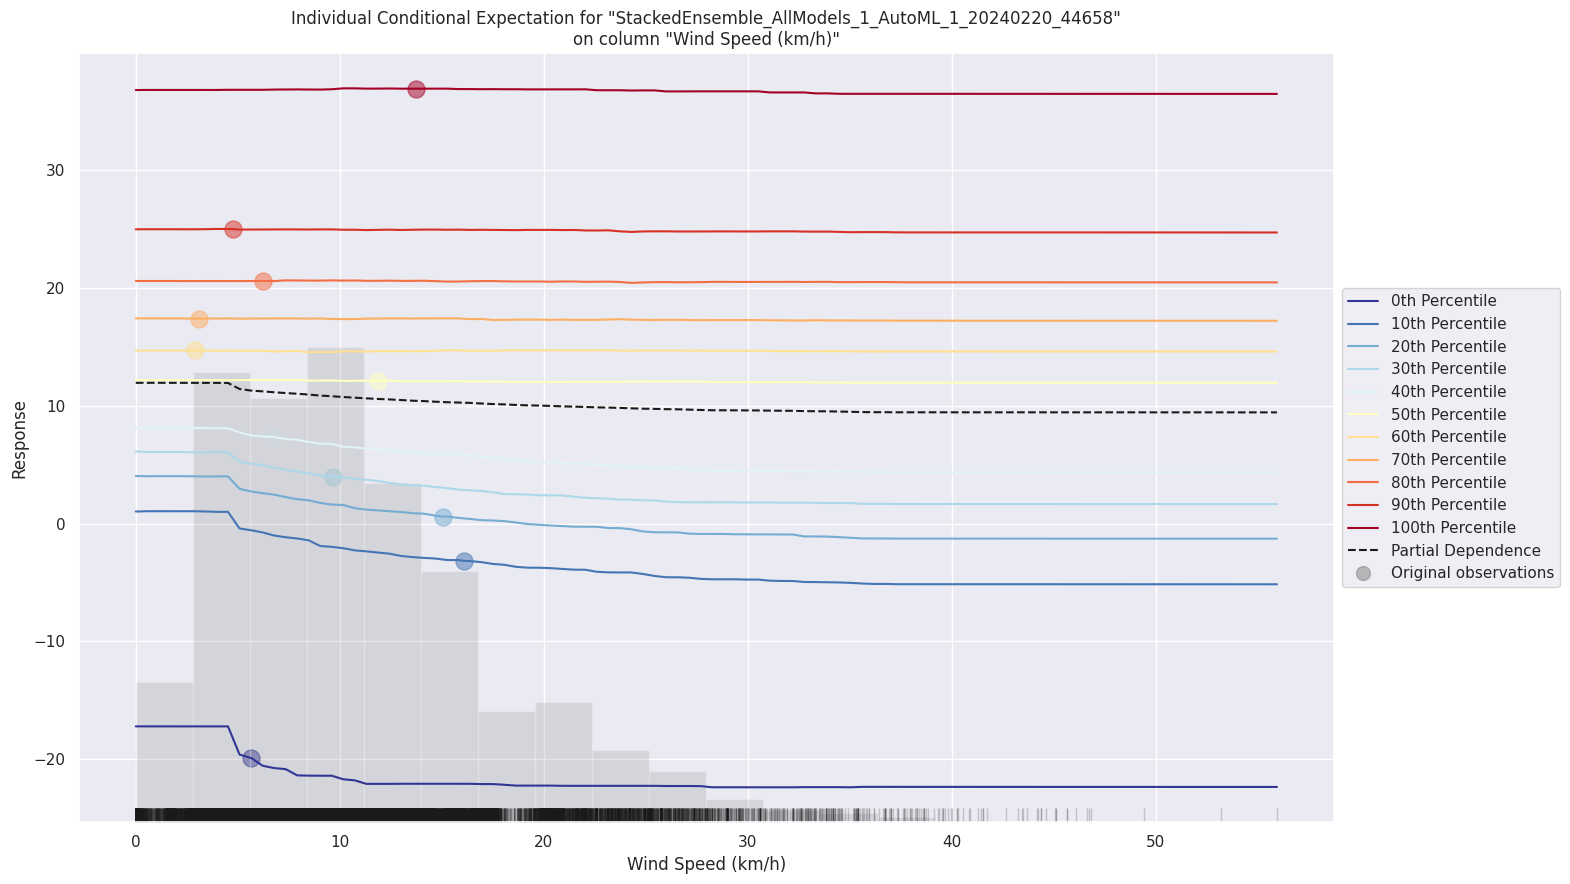

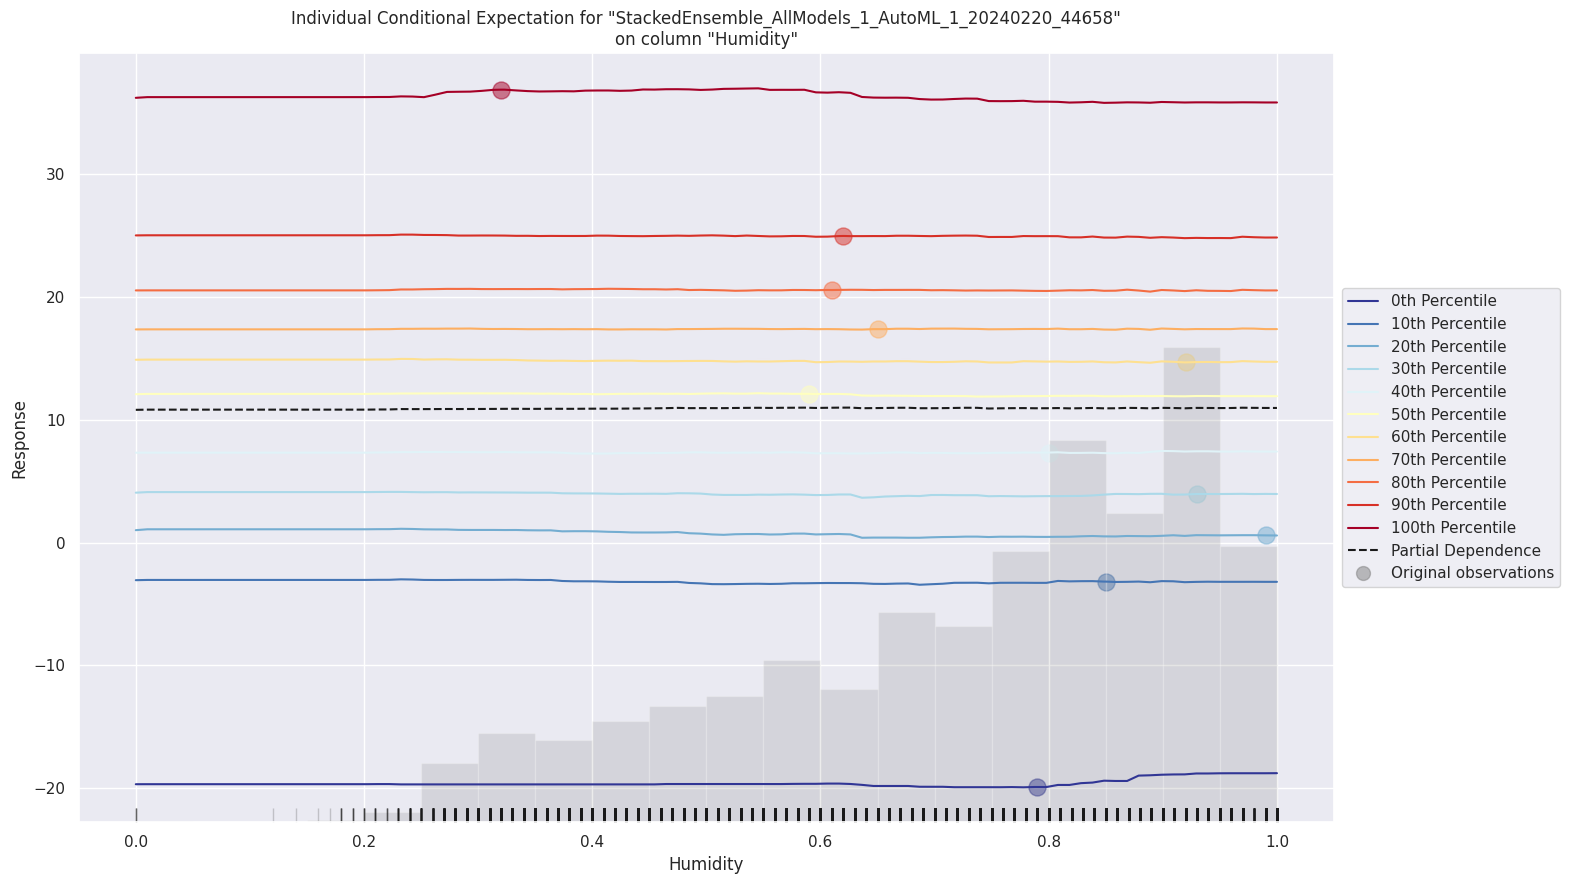

In [53]:
exa = aml.explain(df_test)

In [56]:
#Using OLS for finding the p value to check the significant features
import statsmodels.api as sm

model = sm.OLS(pandas_df['Apparent Temperature (C)'], pandas_df[[

 'Temperature (C)',
 'Humidity',
 'Wind Speed (km/h)',
 'Wind Bearing (degrees)',
 'Visibility (km)',
 'Pressure (millibars)']]).fit()

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     Apparent Temperature (C)   R-squared (uncentered):                   0.995
Model:                                  OLS   Adj. R-squared (uncentered):              0.995
Method:                       Least Squares   F-statistic:                          3.062e+06
Date:                      Tue, 20 Feb 2024   Prob (F-statistic):                        0.00
Time:                              05:04:53   Log-Likelihood:                     -1.4617e+05
No. Observations:                     96453   AIC:                                  2.924e+05
Df Residuals:                         96447   BIC:                                  2.924e+05
Df Model:                                 6                                                  
Covariance Type:                  nonrobust                                                  
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Temperature (C)            1.1129      0.000   2420.294      0.000       1.112       1.114
Humidity                   0.0886      0.020      4.475      0.000       0.050       0.127
Wind Speed (km/h)         -0.1061      0.001   -206.086      0.000      -0.107      -0.105
Wind Bearing (degrees)     0.0003   3.31e-05      9.666      0.000       0.000       0.000
Visibility (km)           -0.0129      0.001    -14.052      0.000      -0.015      -0.011
Pressure (millibars)      -0.0012   2.03e-05    -61.520      0.000      -0.001      -0.001
==============================================================================
Omnibus:                      832.914   Durbin-Watson:                   0.437
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1032.317
Skew:                           0.154   Prob(JB):                    6.84e-225
Kurtosis:                       3.403   Cond. No.                     5.74e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 5.74e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [57]:
import h2o

pandas_df = h2o.as_list(df)

Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


In [58]:
train, validate, test = np.split(
    pandas_df.sample(frac=1, random_state=42), [int(0.6 * len(df)), int(0.8 * len(df))]
)

train = h2o.H2OFrame(train)
validate = h2o.H2OFrame(validate)
test = h2o.H2OFrame(test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [59]:
gbm_parameters = {
    "learn_rate": [i * 0.01 for i in range(1, 11)],
    "max_depth": list(range(2, 11)),
    "sample_rate": [i * 0.1 for i in range(5, 11)],
    "col_sample_rate": [i * 0.1 for i in range(1, 11)],
}

In [60]:
search_criteria = {"strategy": "RandomDiscrete", "max_models": 36, "seed": 1}

In [61]:
gbm_grid2 = H2OGridSearch(
    model=H2OGradientBoostingEstimator,
    grid_id="gbm_grid2",
    hyper_params=gbm_parameters,
    search_criteria=search_criteria,
)

In [ ]:
gbm_grid2.train(
    x=X, y=y, training_frame=train, validation_frame=validate, ntrees=100, seed=1
)

gbm Grid Build progress: |█

In [ ]:
gbm_gridperf2 = gbm_grid2.get_grid(sort_by="residual_deviance", decreasing=False)

In [ ]:
gbm_gridperf2

In [ ]:
list_hyperparameters = []
for i in range(36):
    hyperparameters = gbm_gridperf2.get_hyperparams_dict(i)
    list_hyperparameters.append(hyperparameters)

In [ ]:
models = gbm_gridperf2.models

In [ ]:
list_residual_deviance = []
for i in range(36):
    model = models[i]
    performance_metrics = model.model_performance(validate)
    residual_deviance = performance_metrics.mean_residual_deviance()
    list_residual_deviance.append(residual_deviance)

In [ ]:
for i in range(36):
    list_hyperparameters[i]["Residual_Deviance"] = list_residual_deviance[i]

In [ ]:
hyperparameters_dataframe = pd.DataFrame(list_hyperparameters)

In [ ]:
print(hyperparameters_dataframe)

In [ ]:
sns.pairplot(
    hyperparameters_dataframe,
    y_vars=["Residual_Deviance"],
    x_vars=["col_sample_rate", "learn_rate", "max_depth", "sample_rate"],
)

Hyperparameter tuning analysis

This highlights the findings of a hyperparameter tuning analysis performed on an XGBoost model. The study entailed a grid search on four hyperparameters: col_sample_rate, learn_rate, max_depth, and sample_rate, to identify the optimal combination of hyperparameters based on the lowest Residual Deviance, which was used as an evaluation metric.

The analysis examined a total of 36 hyperparameter combinations. The study found that the col_sample_rate of 0.3, learn_rate of 0.03, max_depth of 8, and sample_rate of 1.0 produced the lowest Residual Deviance. The worst-performing models had Residual Deviances above 0.43, while the next best models had Residual Deviances in the range of 0.36-0.39.

The results highlight the potential of hyperparameter tuning in optimizing XGBoost model performance. The study emphasizes the importance of evaluating hyperparameters and Residual Deviance to identify the optimal combination of hyperparameters and improve model performance.

Overall, the report provides valuable insights into the impact of hyperparameters on XGBoost models and demonstrates the potential for hyperparameter tuning to deliver significant improvements in model performance.

* **Is the relationship significant?**

Yes, r^2 with 0.99 indicates a good fit of the model to the data, implies high explanatory power

* **Are any model assumptions violated?**

Assumptions for linear regression are:

Linear relationship- The graph for dependent and independent variable needs to be linear by keeping other variables constant. When target variable is plotted against all other independent variables, linear relation is observed for few of them. Hence this assumption is not violated.
Homoscedasticity which means normality of the error distribution - The plot for residuals should be normally distributed i.e., it should form a bell-curve shape. For this model the same is achieved.
No or little multicollinearity-This can be determined by correlation matrix. For this model some of the assumptions are violated. Multicollinearity exists between Temperature and Apparent Temperature.
 therefore this assumption is not violated.


* **Is there any multicollinearity in the model?**

 Multicollinearity exists between Temperature and Apparent Temperature.

* **In the multivariate models are predictor variables independent of all the other predictor variables**?
To check this relation, correlation matrix can be used, or it can be observed from graphs too whether there is any pattern followed or not. When correlation matrix is computed for the model, it can be observed that Temperature and Apparent Temperature are correlated to each other. Other than those other predictors are independent from each other.


* **In in multivariate models rank the most significant predictor variables and exclude insignificant ones from the model.**

 From the variable importance plot, the most to least important variables are displayed. For my model Temperature, Visibility, Precip Type and Humidity are top 4 most important variables to determine Price. So those variables were excluded from the model.



* **Does the model make sense?**

For a model to make sense it should follow all the assumptions and have p value. RMSE should be as low as possible considering the minimum and maximum values of the target variable. Other than that, R2 too is 0.98 which is considered good in terms of accuracy. So overall the model makes sense. To increase the accuracy, some additional variables can be dropped depending on their importance. Furthermore, outliers can be removed or boosting, or ensemble model can be used.


* **Does regularization help?**
---- yes, Lasso regularization  

* **Which independent variables are significant?**
Temperature, Hhumidity and Visibility are some significant variables.

* **Which hyperparameters are important?**
---learn_rate, max_depth, and sample_rate appear to be the most important hyperparameters in this set of results because changes in these parameters show more consistent effects on the Residual Deviance. The col_sample_rate appears to be less influential or requires a more nuanced analysis to understand its impact fully


Reference:https://github.com/aiskunks/YouTube/blob/main/A_Crash_Course_in_Statistical_Learning/AutoML/AutoML_Wine_Quality.ipynb

MIT License

Copyright (c) 2024 Tejaswitallapally

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.